In [1]:
import numpy as np
import pandas as pd
from pylab import *
from palettable.colorbrewer.qualitative import Set2_7
import h5py
from pathlib import Path
from domainbed.lib import FFT
from scipy import signal
from scipy.interpolate import interp2d
import scipy.io as scio


In [2]:
colors = Set2_7.mpl_colors

params = {
    'axes.labelsize': 8,
    'font.size': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5]
}
rcParams.update(params)
plt.style.use(['science', 'no-latex', 'cjk-sc-font'])

# Fig 1: 变转速时频、频谱绘制

In [4]:
data_path = Path("D:\datasets\复合故障数据集\数据\Case 1")
file_path = data_path / "B4L.h5"
read_file = h5py.File(file_path, 'r')
signals = pd.DataFrame(np.array(read_file['x']))
read_file.close()
pre_second = 2
sig = signals.iloc[0][2560 * pre_second:2560 * pre_second + 51200 * 2]
sampling_frequency = 5120
nperseg = 255
noverlap = 170

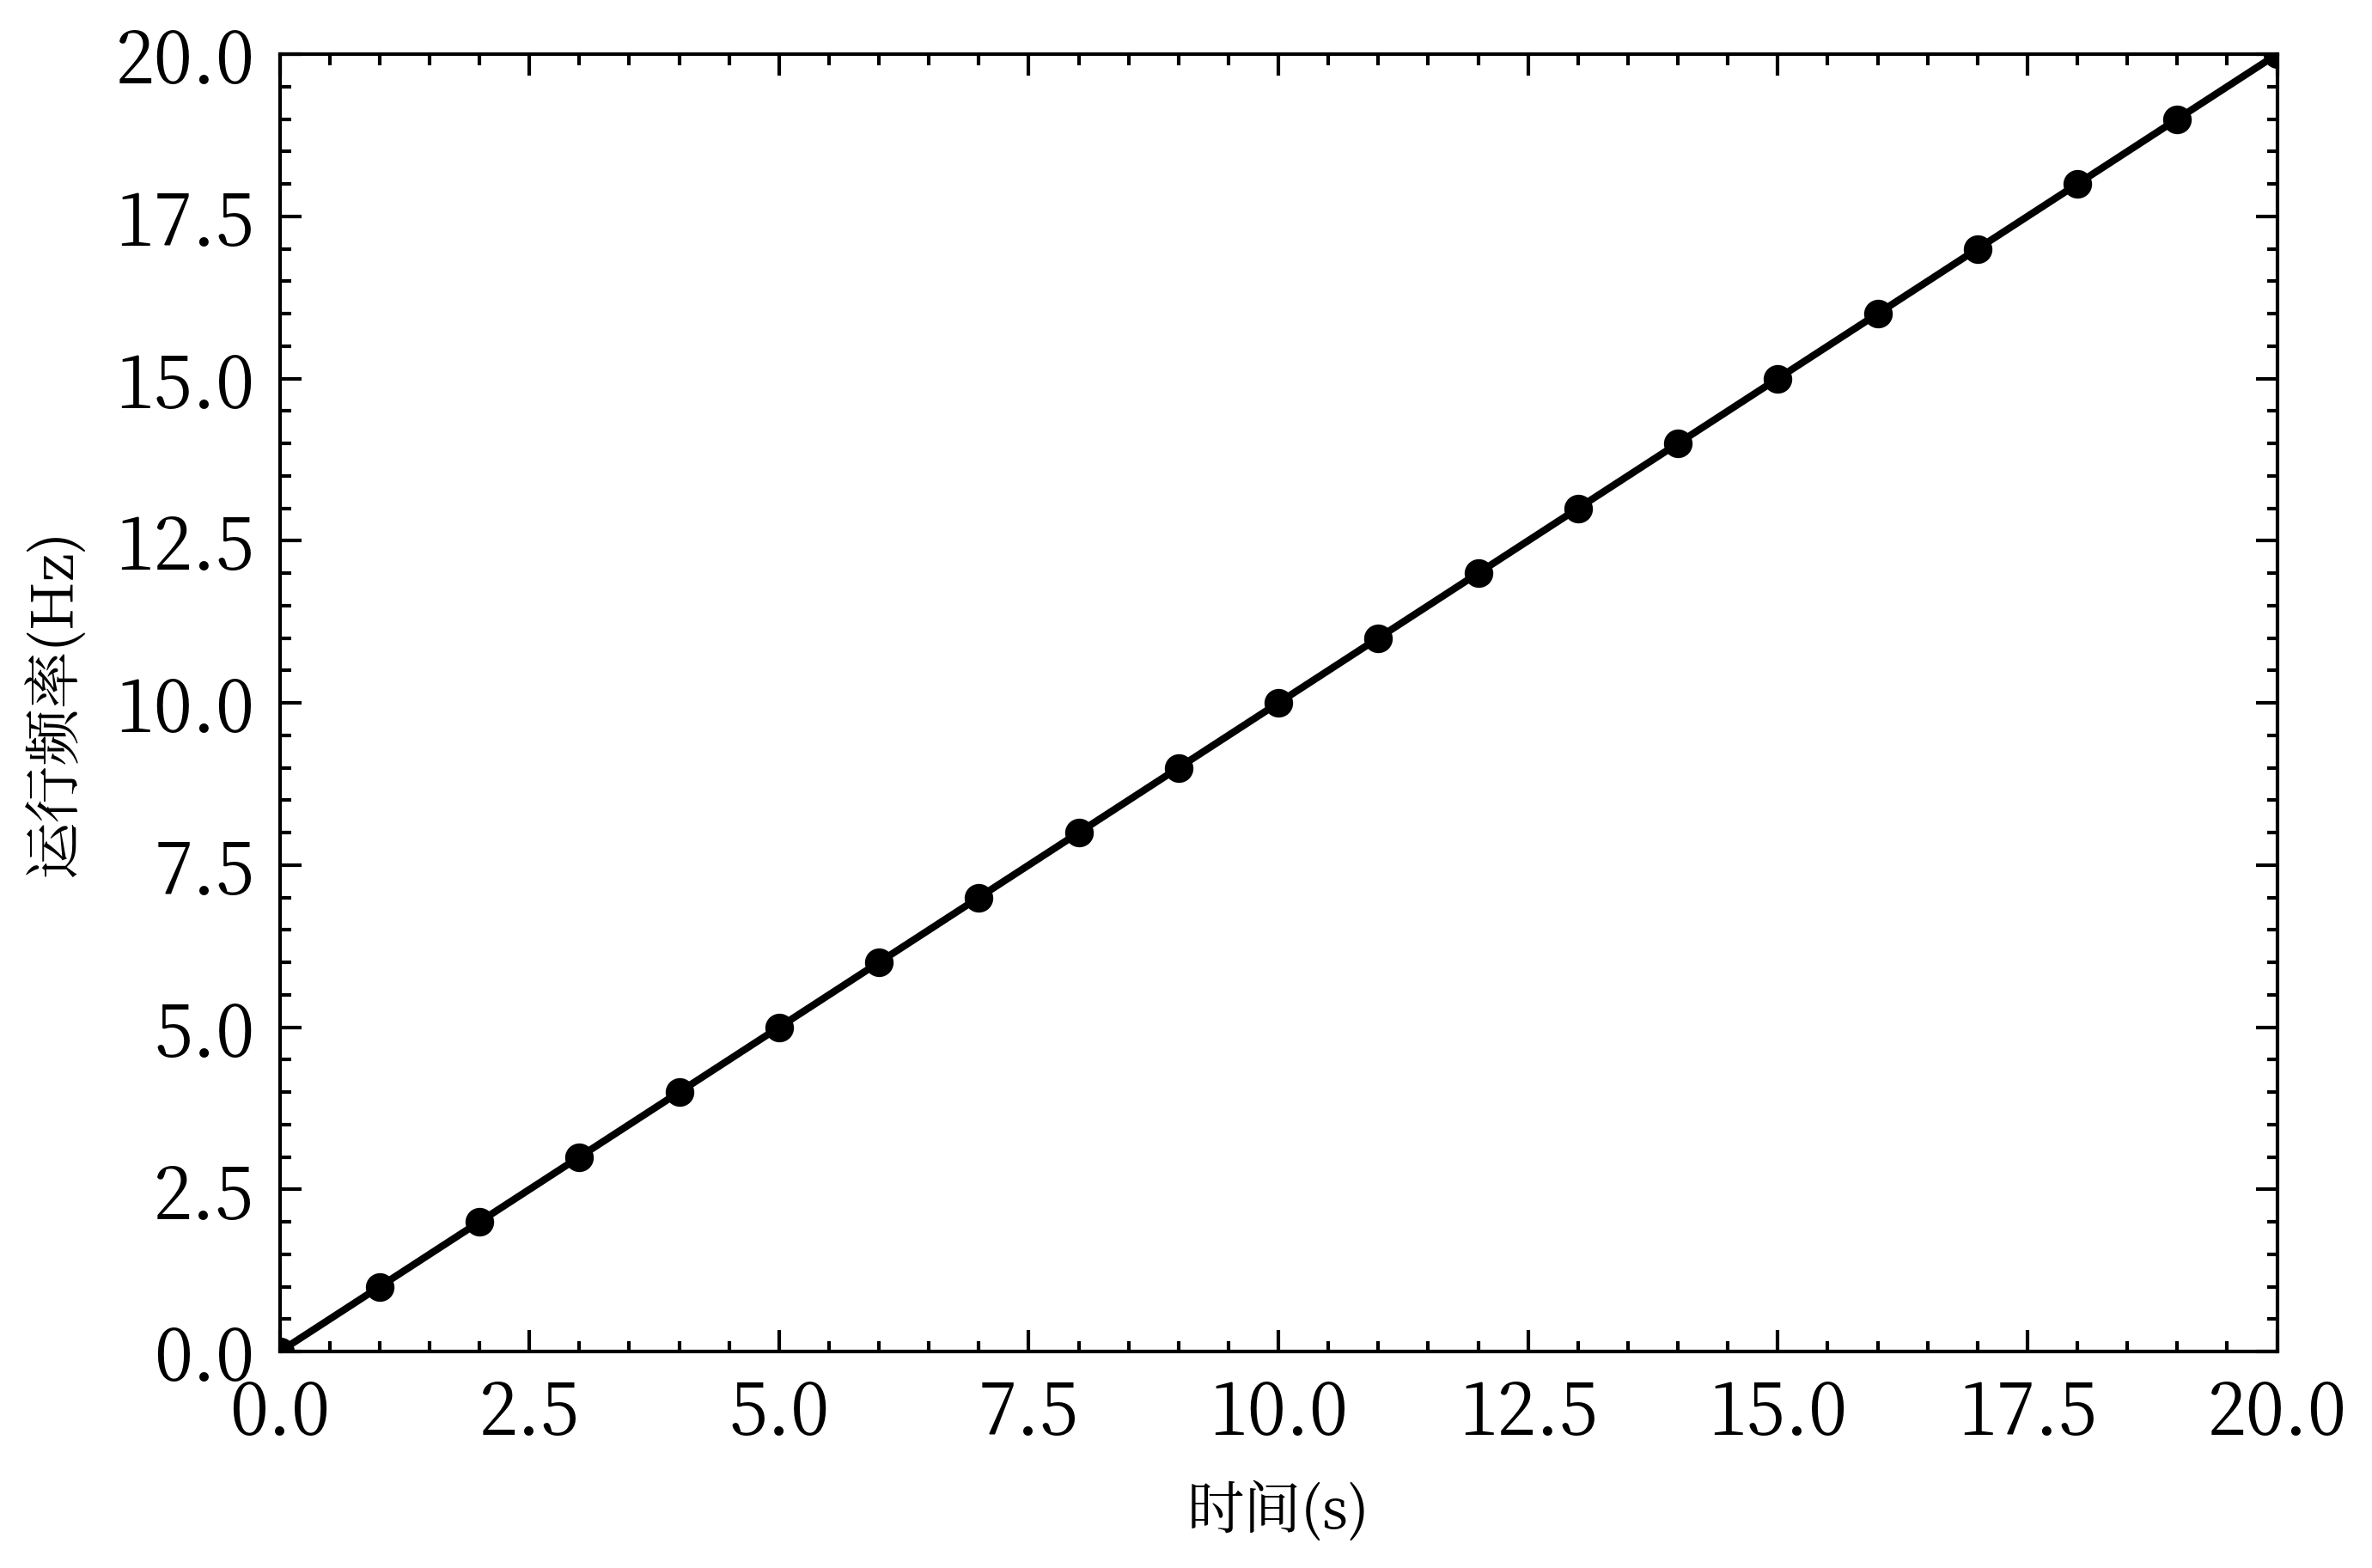

In [50]:
speedFilePath = Path("D:\datasets\复合故障数据集\工况设置\CLTC.mat")
data = scio.loadmat(speedFilePath)
data = data['CLTC_P']

x = np.arange(0, 21)
y = np.arange(0, 21)

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
ax.plot(x, y, '.-', linewidth=1, color='black')
# 设置x、y轴标签
ax.set_ylabel("运行频率(Hz)")
ax.set_xlabel("时间(s)")
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
plt.savefig('figs/speed.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)

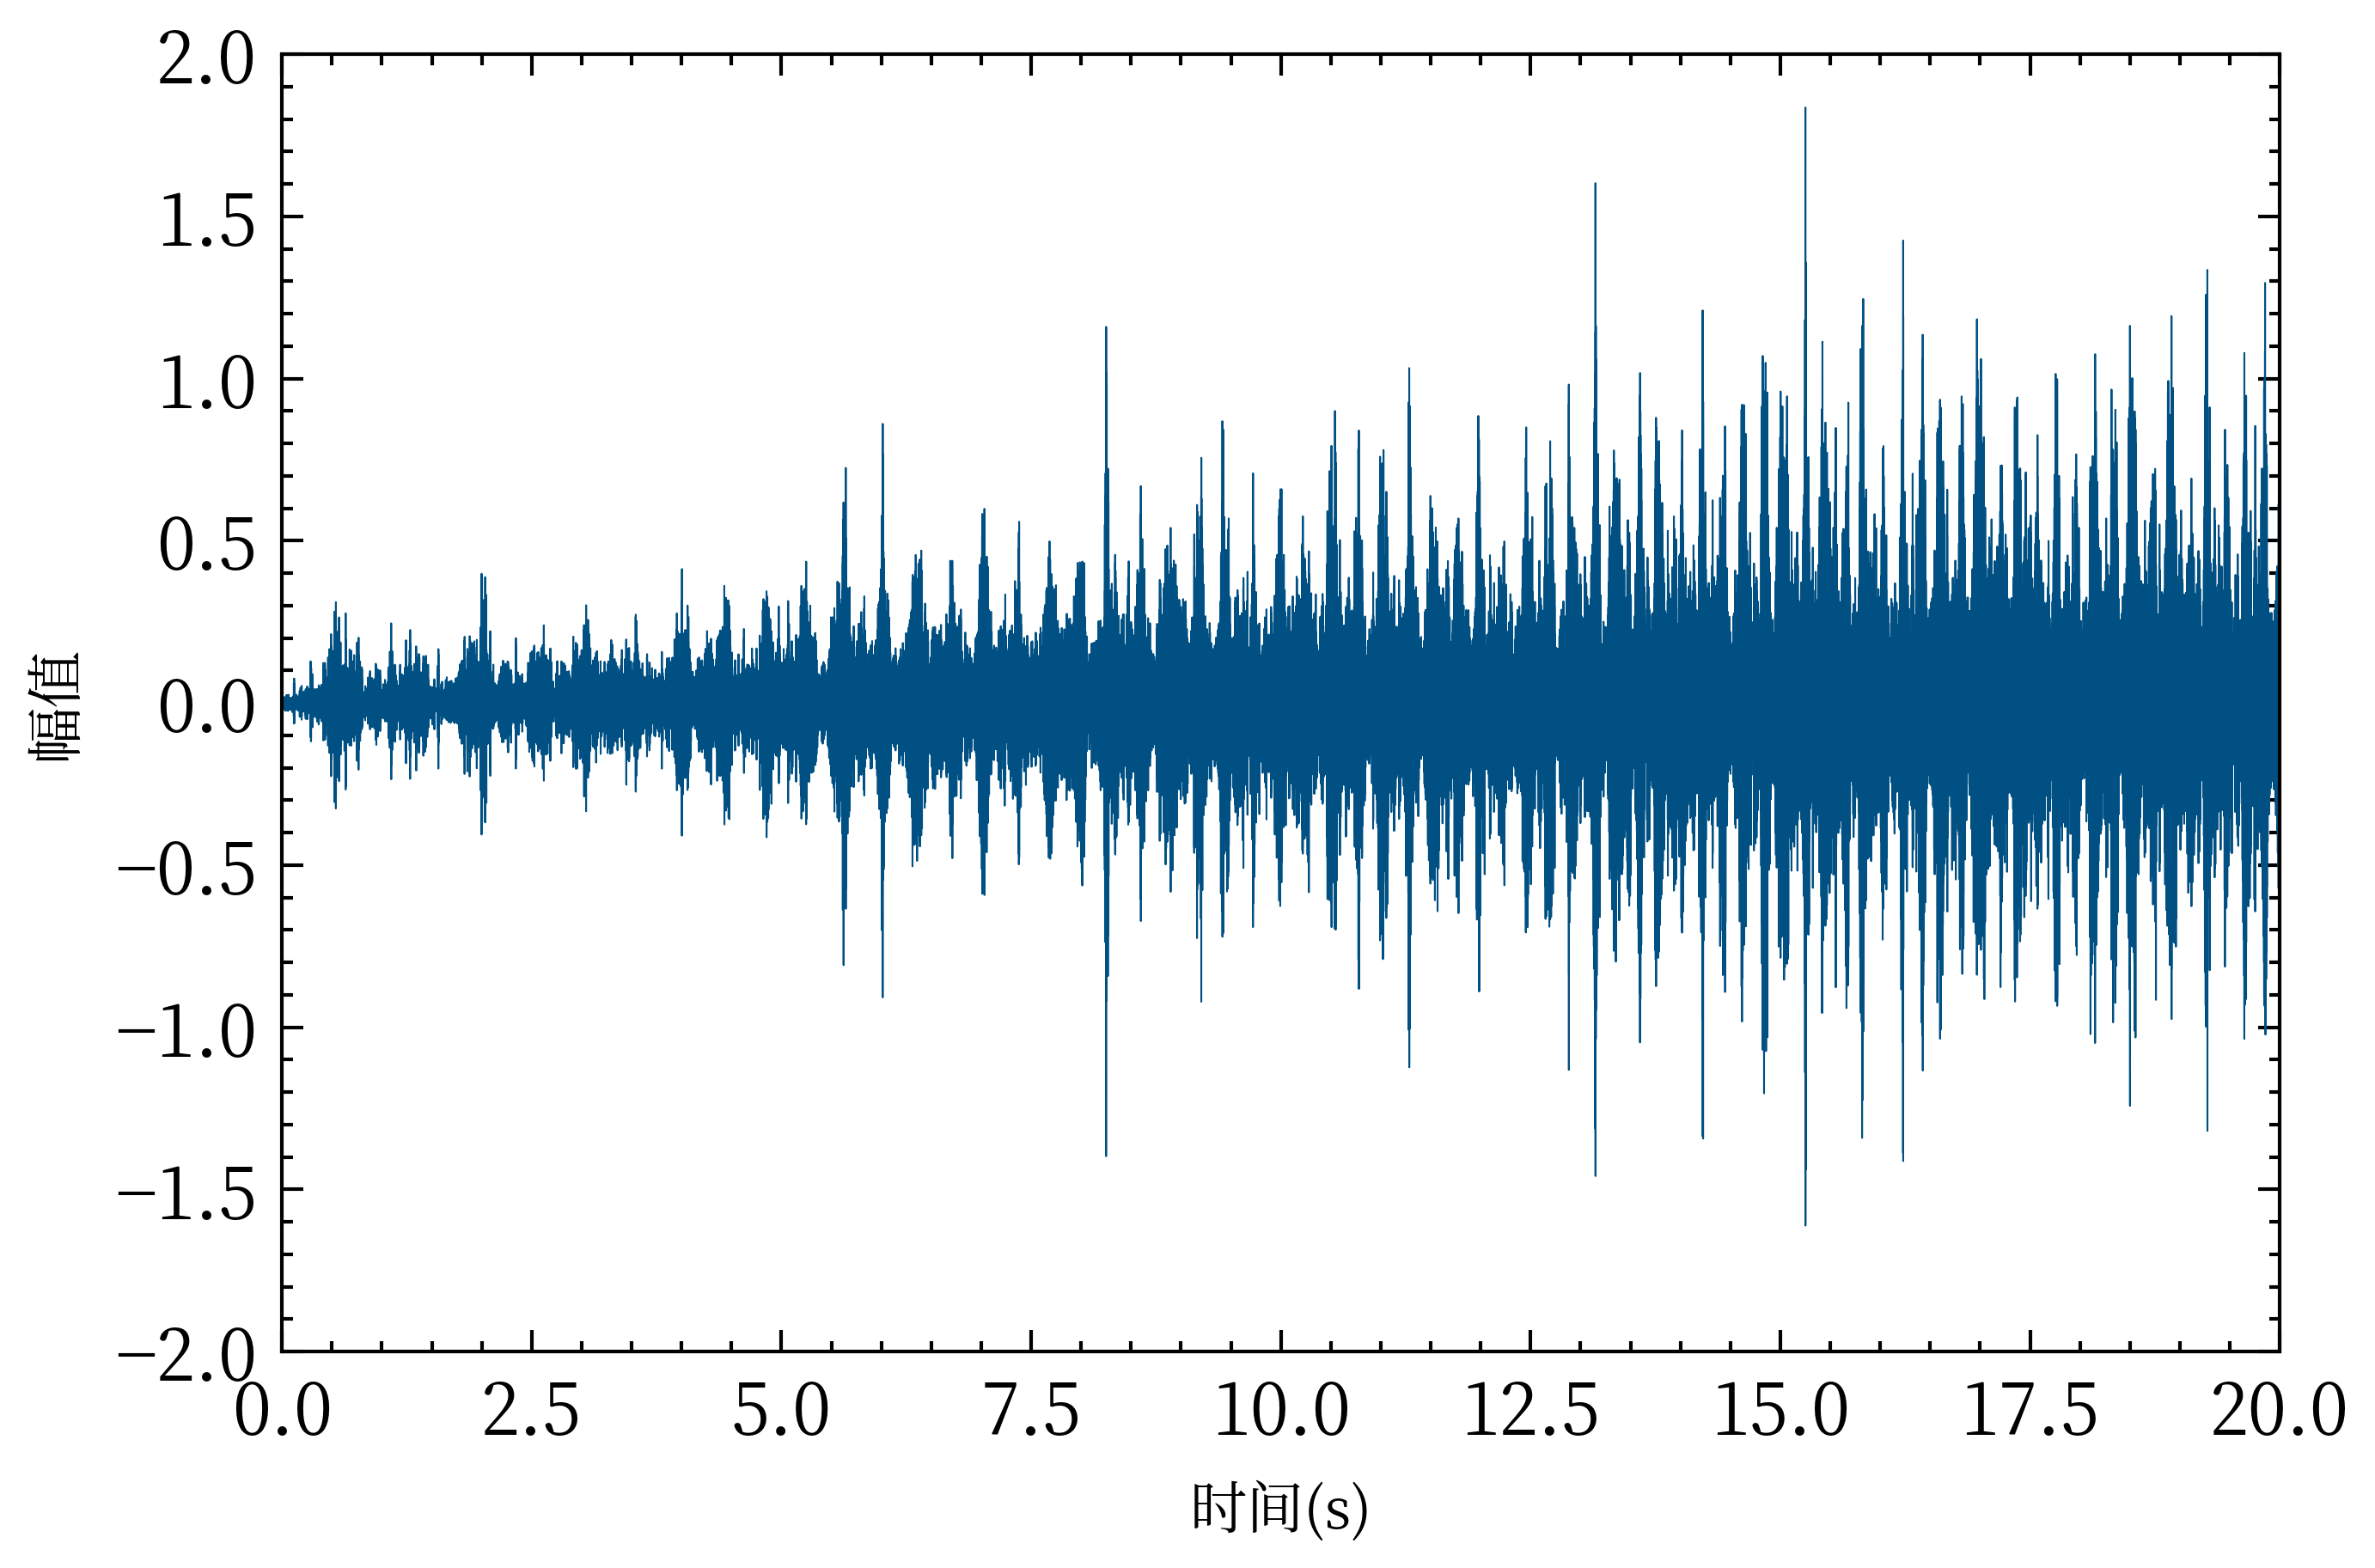

In [6]:


# fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)
# ax[0].plot(np.arange(0, len(sig)), sig)
# fre, amp = FFT.fft(sig, sampling_frequency)
# ax[1].plot(fre, amp)
# f, t, Zxx = signal.stft(sig, sampling_frequency, window='tukey', nperseg=nperseg, noverlap=noverlap)
# newF = interp2d(t, f, np.abs(Zxx), kind='linear')
# t_new = np.linspace(0, 1 / sampling_frequency * 5120, num=x_len)
# f_new = np.linspace(0, sampling_frequency // 2, num=f_len)
# Z_new = newF(t_new, f_new)
# Xn, Yn = np.meshgrid(t_new, f_new)
# ax[2].pcolormesh(Xn, Yn, Z_new, shading='auto')
# ax[2].axis('off')

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)

ax.plot(np.arange(0, len(sig)) / 5120, sig, color=(0, 80 / 255, 131 / 255), linewidth=0.25)

# change xlim to set_xlim
ax.set_xlim(0, len(sig) / 5120)
ax.set_ylim(-2, 2)
ax.set_xlabel('时间(s)')
ax.set_ylabel('幅值')
# plt.axis('off')
plt.savefig('figs/varied_signal.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)

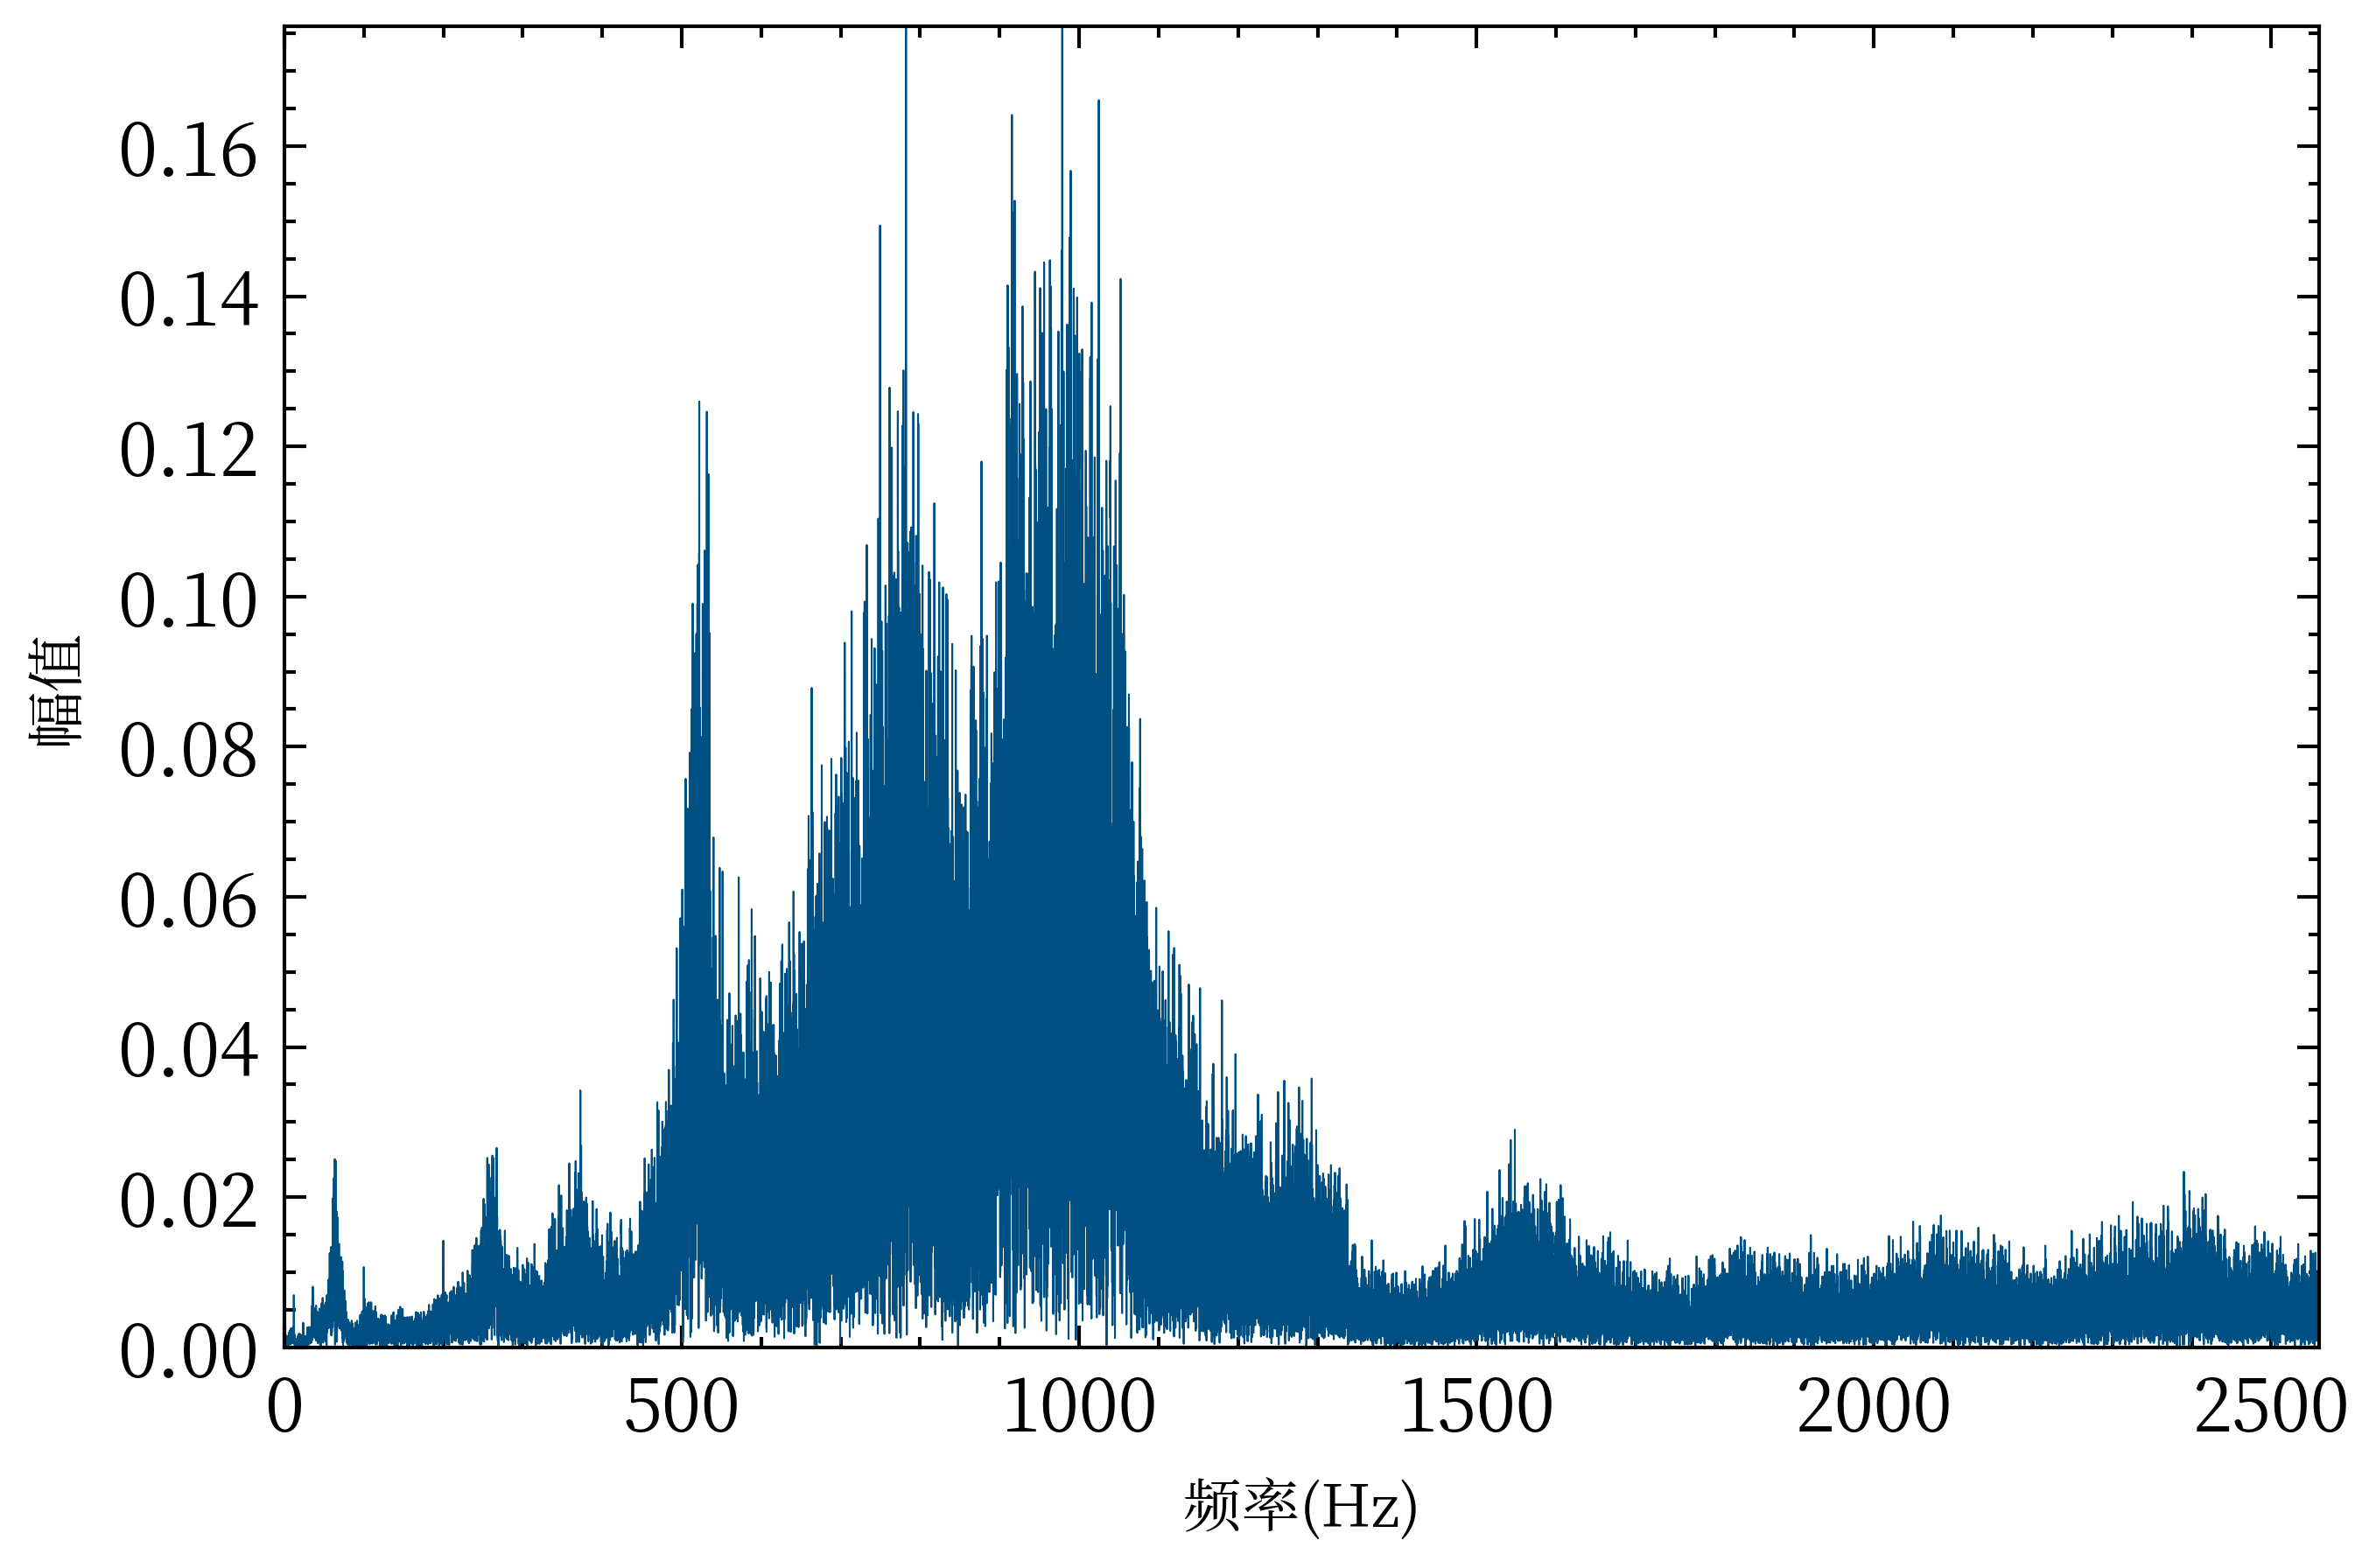

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
fre, amp = FFT.fft(sig, sampling_frequency)
ax.plot(fre, amp, color=(0, 80 / 255, 131 / 255), linewidth=0.25)
ax.set_xlabel('频率(Hz)')
ax.set_ylabel('幅值')
# change xlim to set_xlim
ax.set_xlim(0, 5120 / 2)
ax.set_ylim(0, 0.176)
plt.savefig('figs/varied_signal_fft.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)

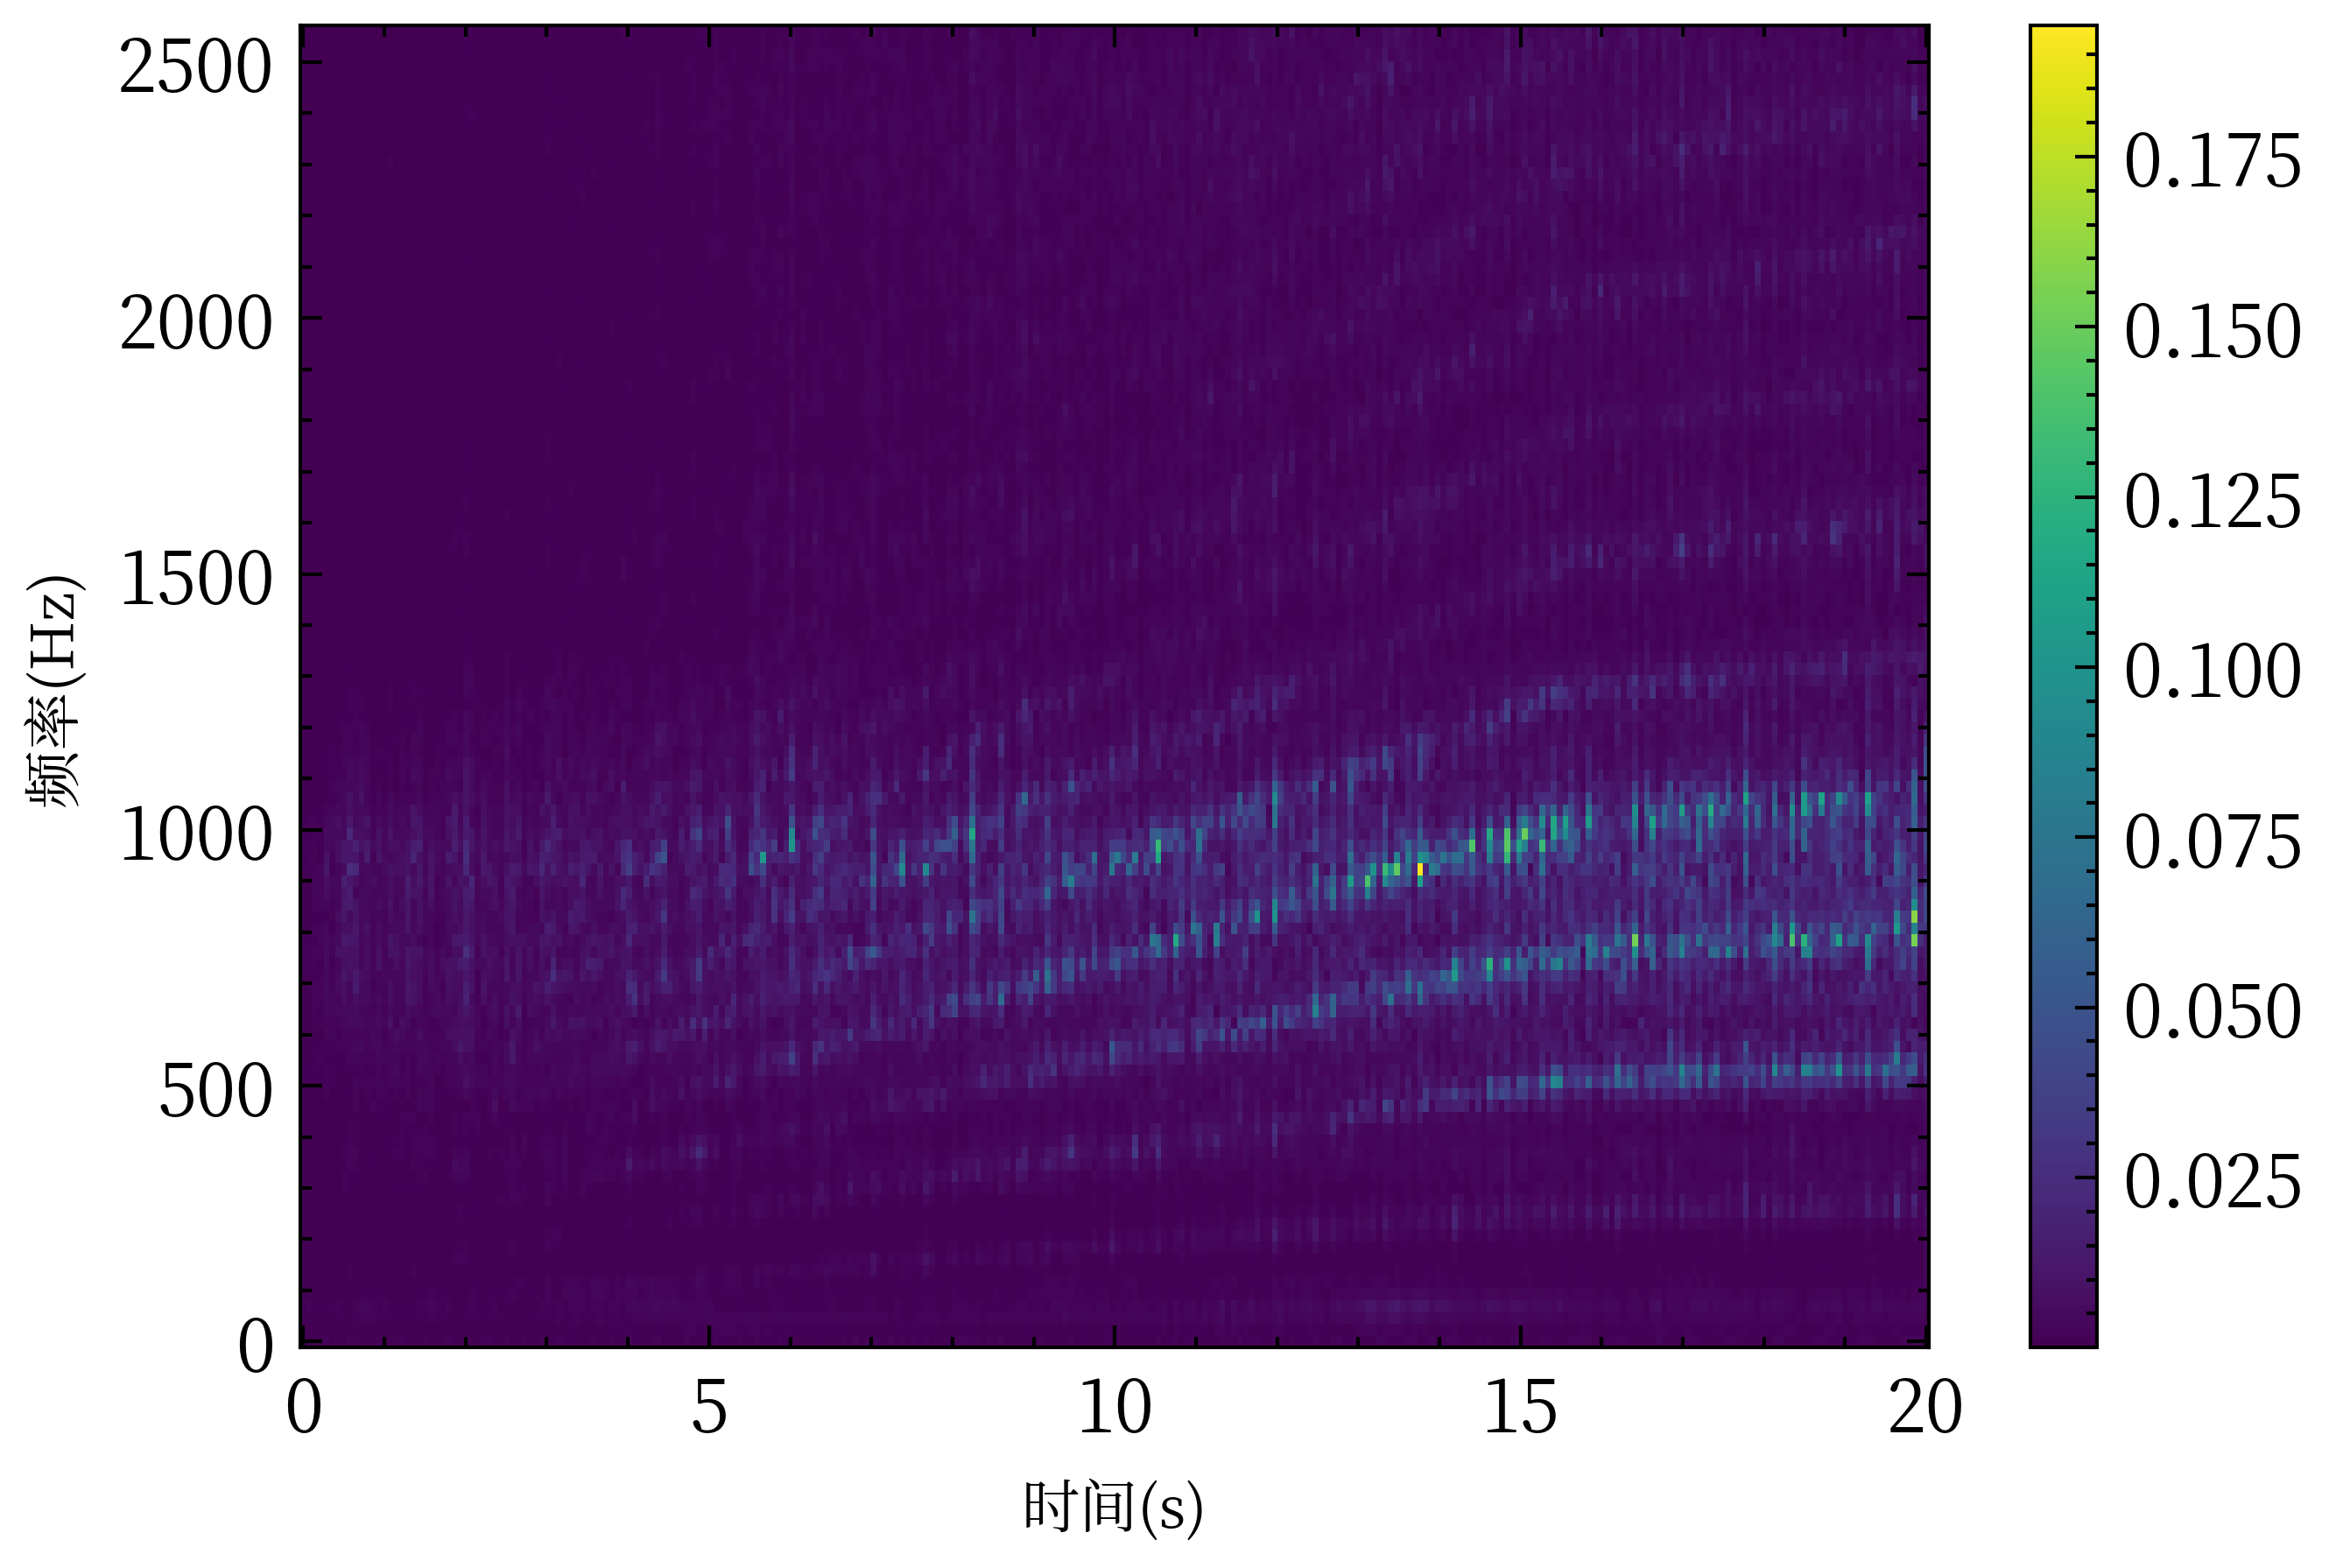

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)

pic_size = 56
x_len = pic_size * 5
f_len = pic_size * 2
f, t, Zxx = signal.stft(sig, sampling_frequency, window='tukey', nperseg=nperseg, noverlap=noverlap)
newF = interp2d(t, f, np.abs(Zxx), kind='linear')
t_new = np.linspace(0, 1 / sampling_frequency * 5120 * 20, num=x_len)
f_new = np.linspace(0, sampling_frequency // 2, num=f_len)
Z_new = newF(t_new, f_new)
Xn, Yn = np.meshgrid(t_new, f_new)
im = ax.pcolormesh(Xn, Yn, Z_new, shading='auto')
ax.set_xlabel('时间(s)')
ax.set_ylabel('频率(Hz)')
fig.colorbar(im)
plt.savefig('figs/varied_signal_stft.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)

# Fig 2: 训练集训练过程

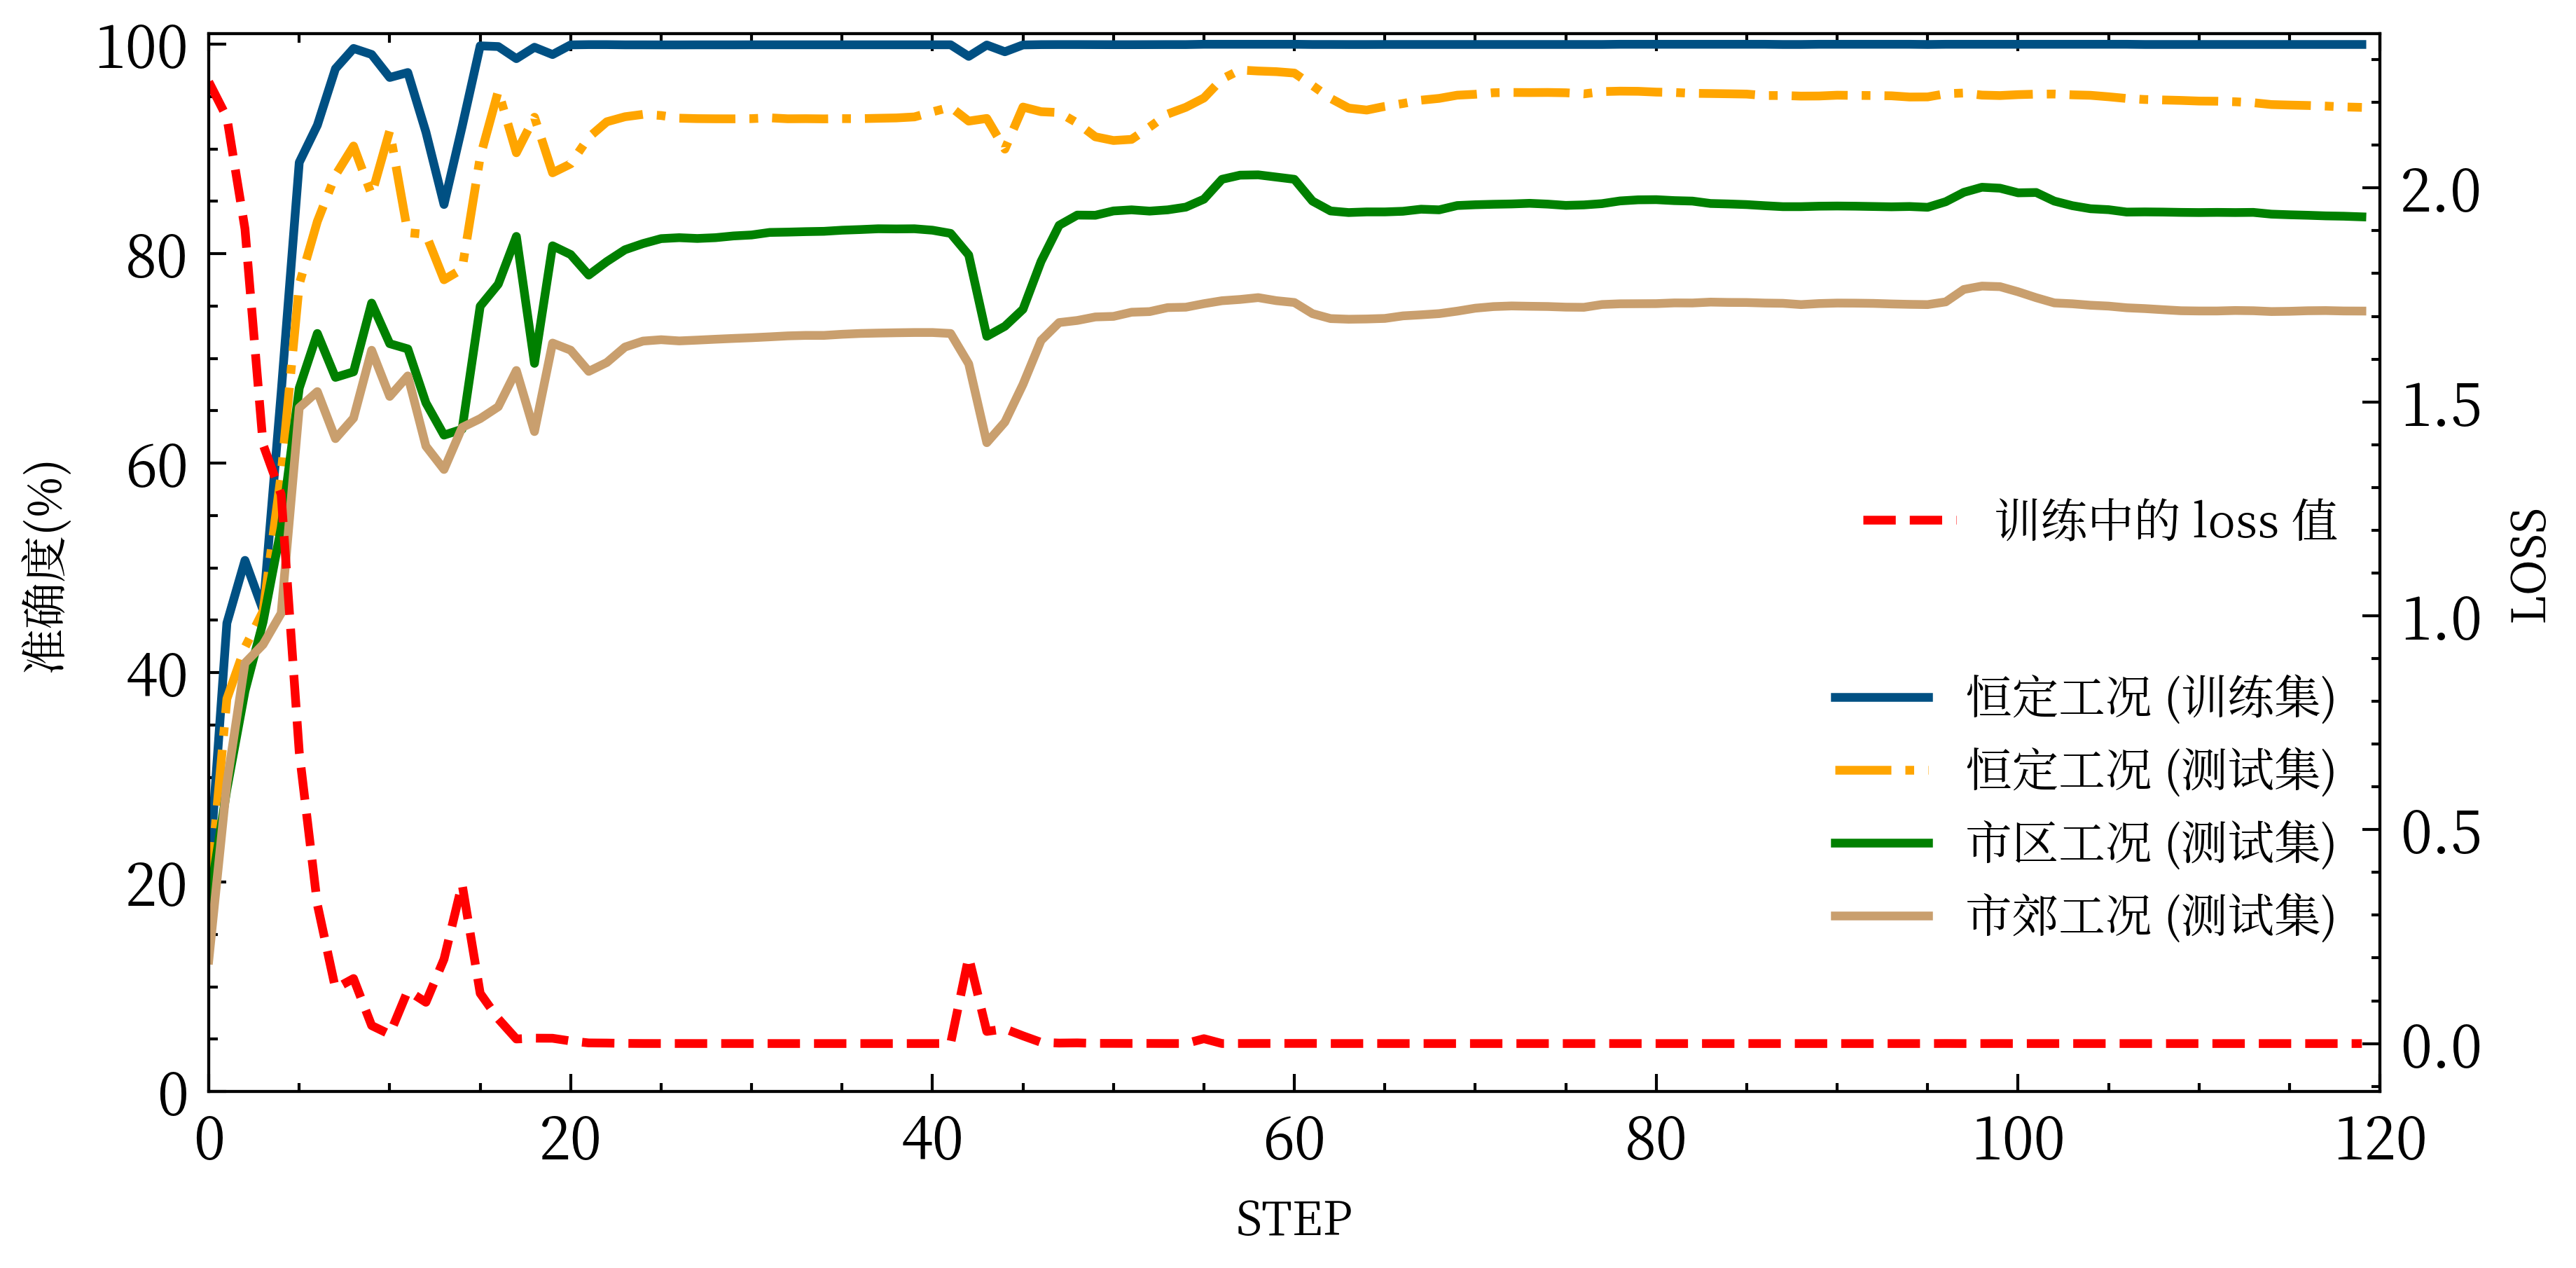

In [97]:
file_path = Path("./result.xlsx")
xl = pd.ExcelFile(file_path)
df = xl.parse('train_91')
cut_off = 120
# 恒定工况训练准确度 = HL+LL+ML/6
df['train_const_speed'] = (df['HL13_in_acc'] + df['HL13_out_acc'] + df['LL15_in_acc'] + df['LL15_out_acc'] + df[
    'ML17_in_acc'] + df['ML17_out_acc']) / 6

# 恒定工况测试准确度
df['test_const_speed'] = (df['HH12_in_acc'] + df['HH12_out_acc'] + df['LH14_in_acc'] + df['LH14_out_acc'] + df[
    'MH16_in_acc'] + df['MH16_out_acc']) / 6

# 市区工况测试准确度
df['test_udc'] = (df['B4L09_in_acc'] + df['B4L09_out_acc']) / 2

# 市郊工况测试准确度
df['test_eudc'] = (df['B4L110_in_acc'] + df['B4L110_out_acc'] + df['B4L211_in_acc'] + df['B4L211_out_acc']) / 4

fig, ax = plt.subplots(1, 1, figsize=(8 / 1.2, 4 / 1.2), dpi=600)
ax.plot(df.index[:cut_off], df['train_const_speed'][:cut_off] * 100, linewidth=1.5, linestyle='-',
        markersize=2,
        color=(0, 80 / 255, 131 / 255),
        label='恒定工况 (训练集)')
ax.plot(df.index[:cut_off], df['test_const_speed'][:cut_off] * 100, linewidth=1.5, linestyle='-.',
        markersize=2,
        color='orange',
        label='恒定工况 (测试集)')
ax.plot(df.index[:cut_off], df['test_udc'][:cut_off] * 100, linewidth=1.5, linestyle='-', markersize=2,
        color='green',
        label='市区工况 (测试集)')
ax.plot(df.index[:cut_off], df['test_eudc'][:cut_off] * 100, linewidth=1.5, linestyle='-', markersize=2,
        color=(201 / 255, 159 / 255, 110 / 255),
        label='市郊工况 (测试集)')
ax.set_ylabel('准确度(%)')
ax.set_xlabel('STEP')
ax.set_xlim(0, cut_off)
ax.set_ylim(0, 101)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0.1))

ax2 = ax.twinx()
ax2.plot(df.index[:cut_off], df['loss'][:cut_off], linewidth=1.5, linestyle='--', markersize=2,
         color='red',
         label='训练中的 loss 值')
ax2.set_ylabel('LOSS')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.6))

plt.savefig('figs/train_process_group_1.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)


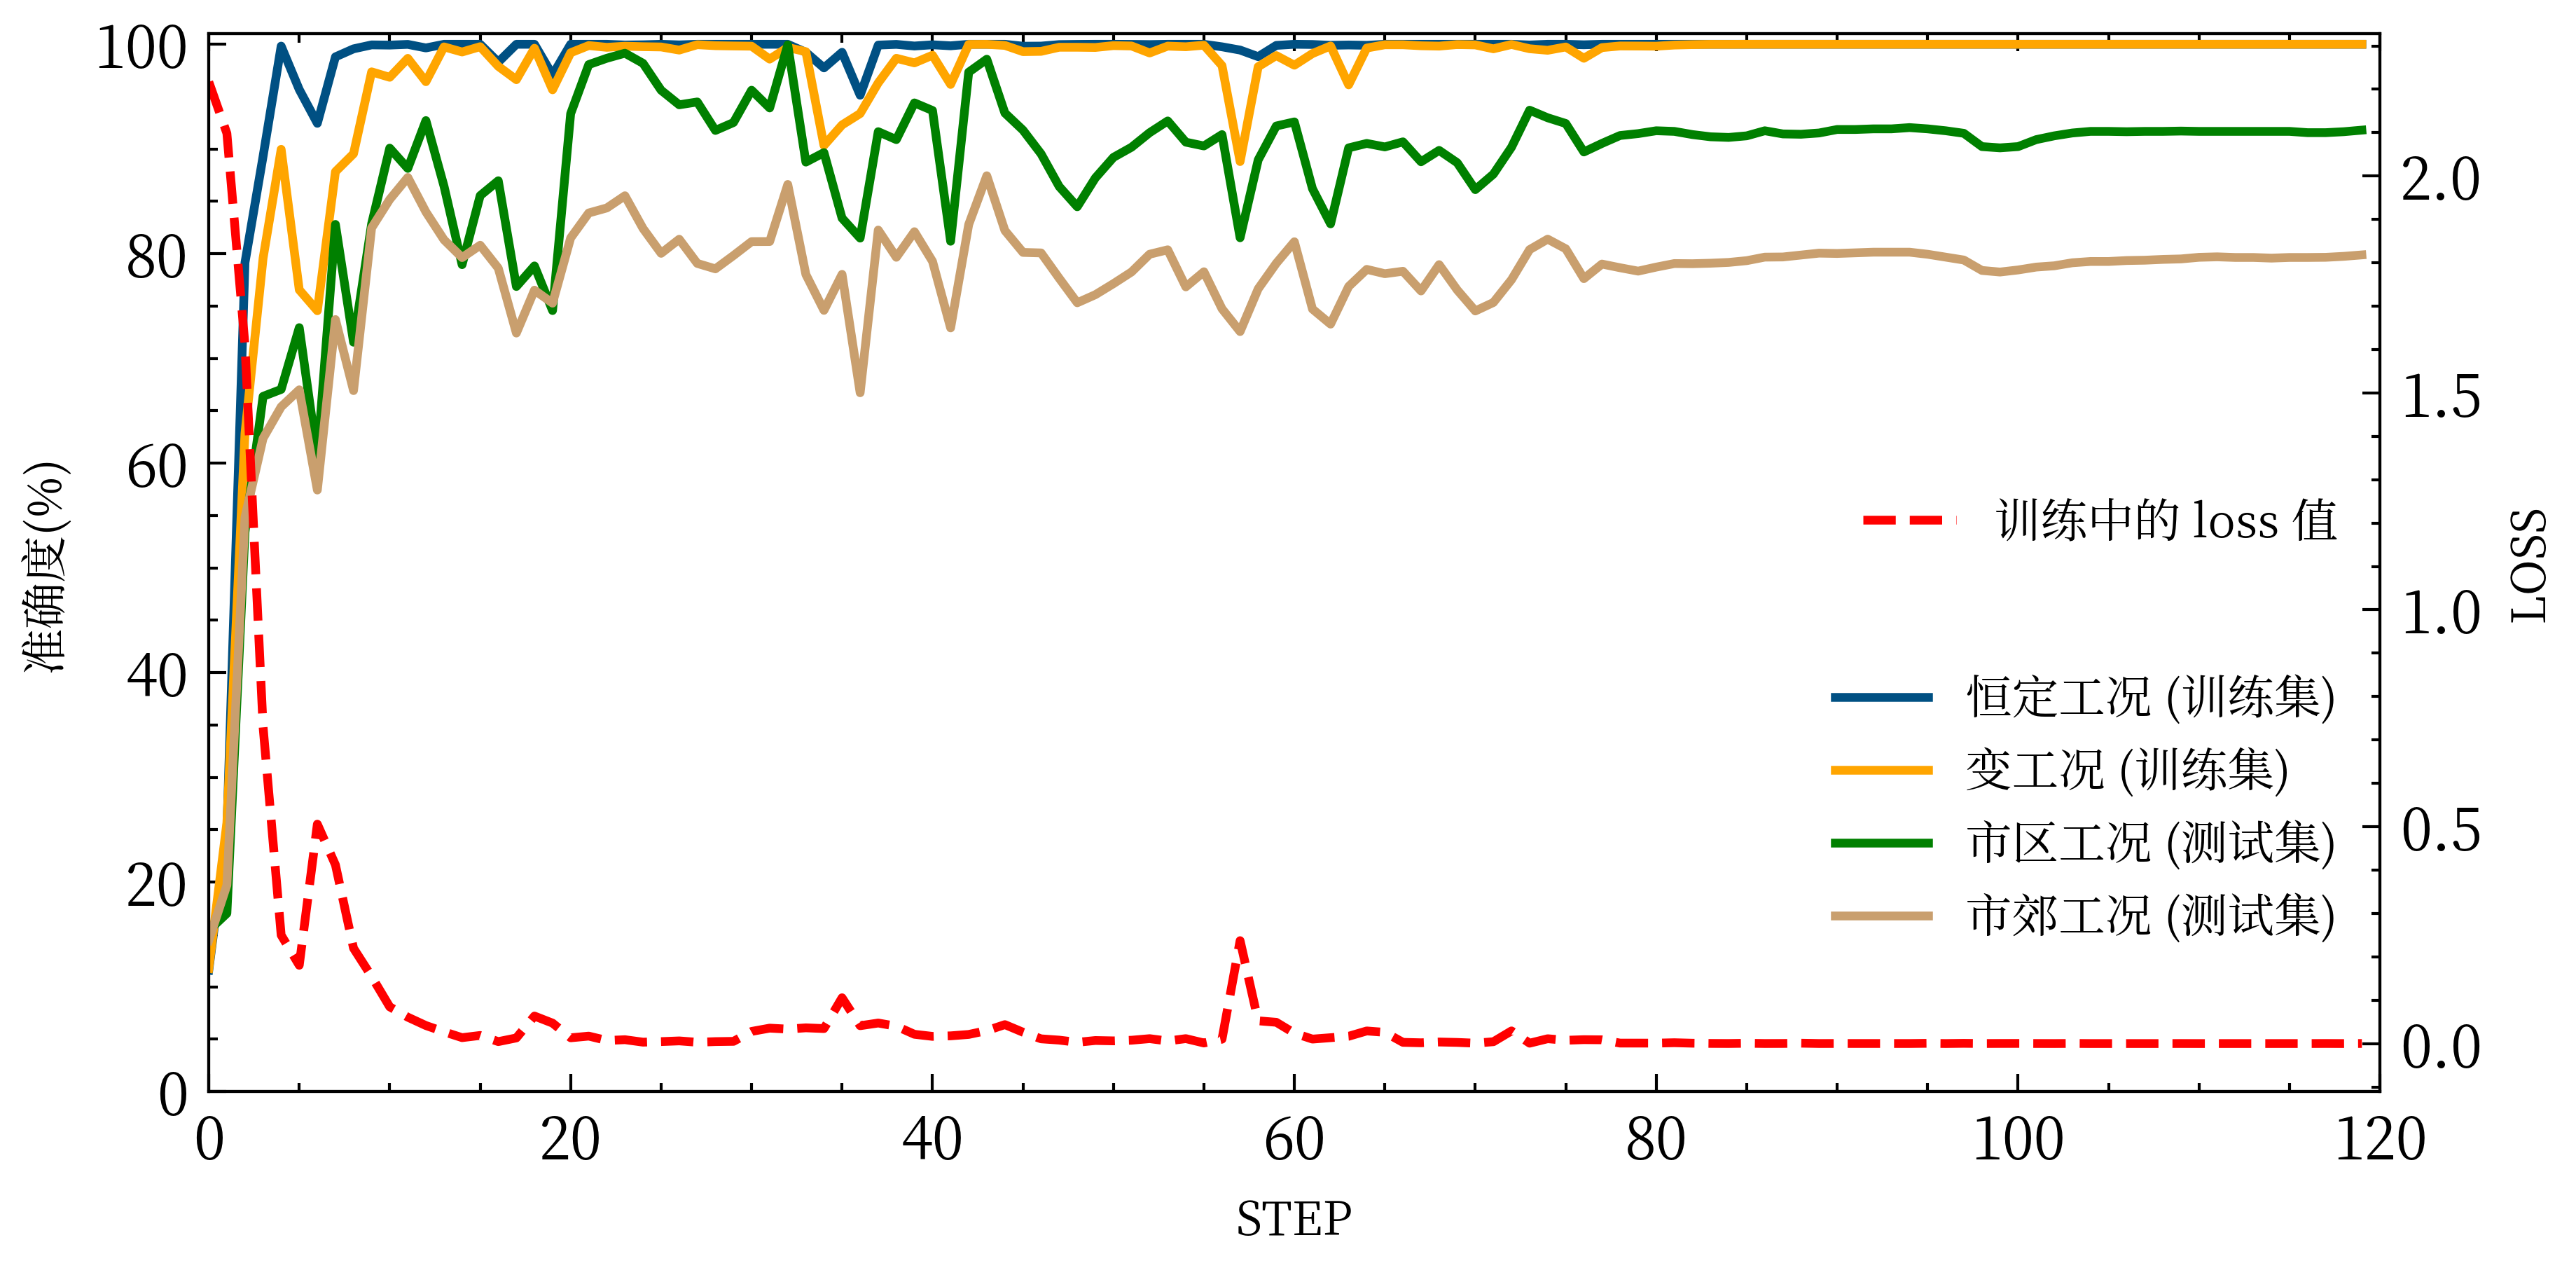

In [104]:
file_path = Path("./result.xlsx")
xl = pd.ExcelFile(file_path)
df = xl.parse('trainWithB123')

# 恒定工况训练准确度 = HL+LL+ML/6
df['train_const_speed'] = (df['HL13_in_acc'] + df['HL13_out_acc'] + df['LL15_in_acc'] + df['LL15_out_acc'] + df[
    'ML17_in_acc'] + df['ML17_out_acc']) / 6

# 变工况辅助训练准确度
df['train_varied_speed'] = (df['B1L1_in_acc'] + df['B1L1_out_acc'] + df['B2L3_in_acc'] + df['B2L3_out_acc'] + df[
    'B3L5_in_acc'] + df['B3L5_out_acc']) / 6

# 市区工况测试准确度
df['test_udc'] = (df['B4L09_in_acc'] + df['B4L09_out_acc']) / 2

# 市郊工况测试准确度
df['test_eudc'] = (df['B4L110_in_acc'] + df['B4L110_out_acc'] + df['B4L211_in_acc'] + df['B4L211_out_acc']) / 4

fig, ax = plt.subplots(1, 1, figsize=(8 / 1.2, 4 / 1.2), dpi=600)
ax.plot(df.index[:cut_off], df['train_const_speed'][:cut_off] * 100, linewidth=1.5, linestyle='-',
        markersize=2,
        color=(0, 80 / 255, 131 / 255),
        label='恒定工况 (训练集)')
ax.plot(df.index[:cut_off], df['train_varied_speed'][:cut_off] * 100, linewidth=1.5, linestyle='-',
        markersize=2,
        color='orange',
        label='变工况 (训练集)')
ax.plot(df.index[:cut_off], df['test_udc'][:cut_off] * 100, linewidth=1.5, linestyle='-', markersize=2,
        color='green',
        label='市区工况 (测试集)')
ax.plot(df.index[:cut_off], df['test_eudc'][:cut_off] * 100, linewidth=1.5, linestyle='-', markersize=2,
        color=(201 / 255, 159 / 255, 110 / 255),
        label='市郊工况 (测试集)')
ax.set_ylabel('准确度(%)')
ax.set_xlabel('STEP')
ax.set_xlim(0, cut_off)
ax.set_ylim(0, 101)
ax.legend(loc='lower right', bbox_to_anchor=(1, 0.1))

ax2 = ax.twinx()
ax2.plot(df.index[:cut_off], df['loss'][:cut_off], linewidth=1.5, linestyle='--', markersize=2,
         color='red',
         label='训练中的 loss 值')
ax2.set_ylabel('LOSS')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.6))

plt.savefig('figs/train_process_group_2.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)


# Fig 3: 两种训练集下不同故障类型的诊断准确度对比

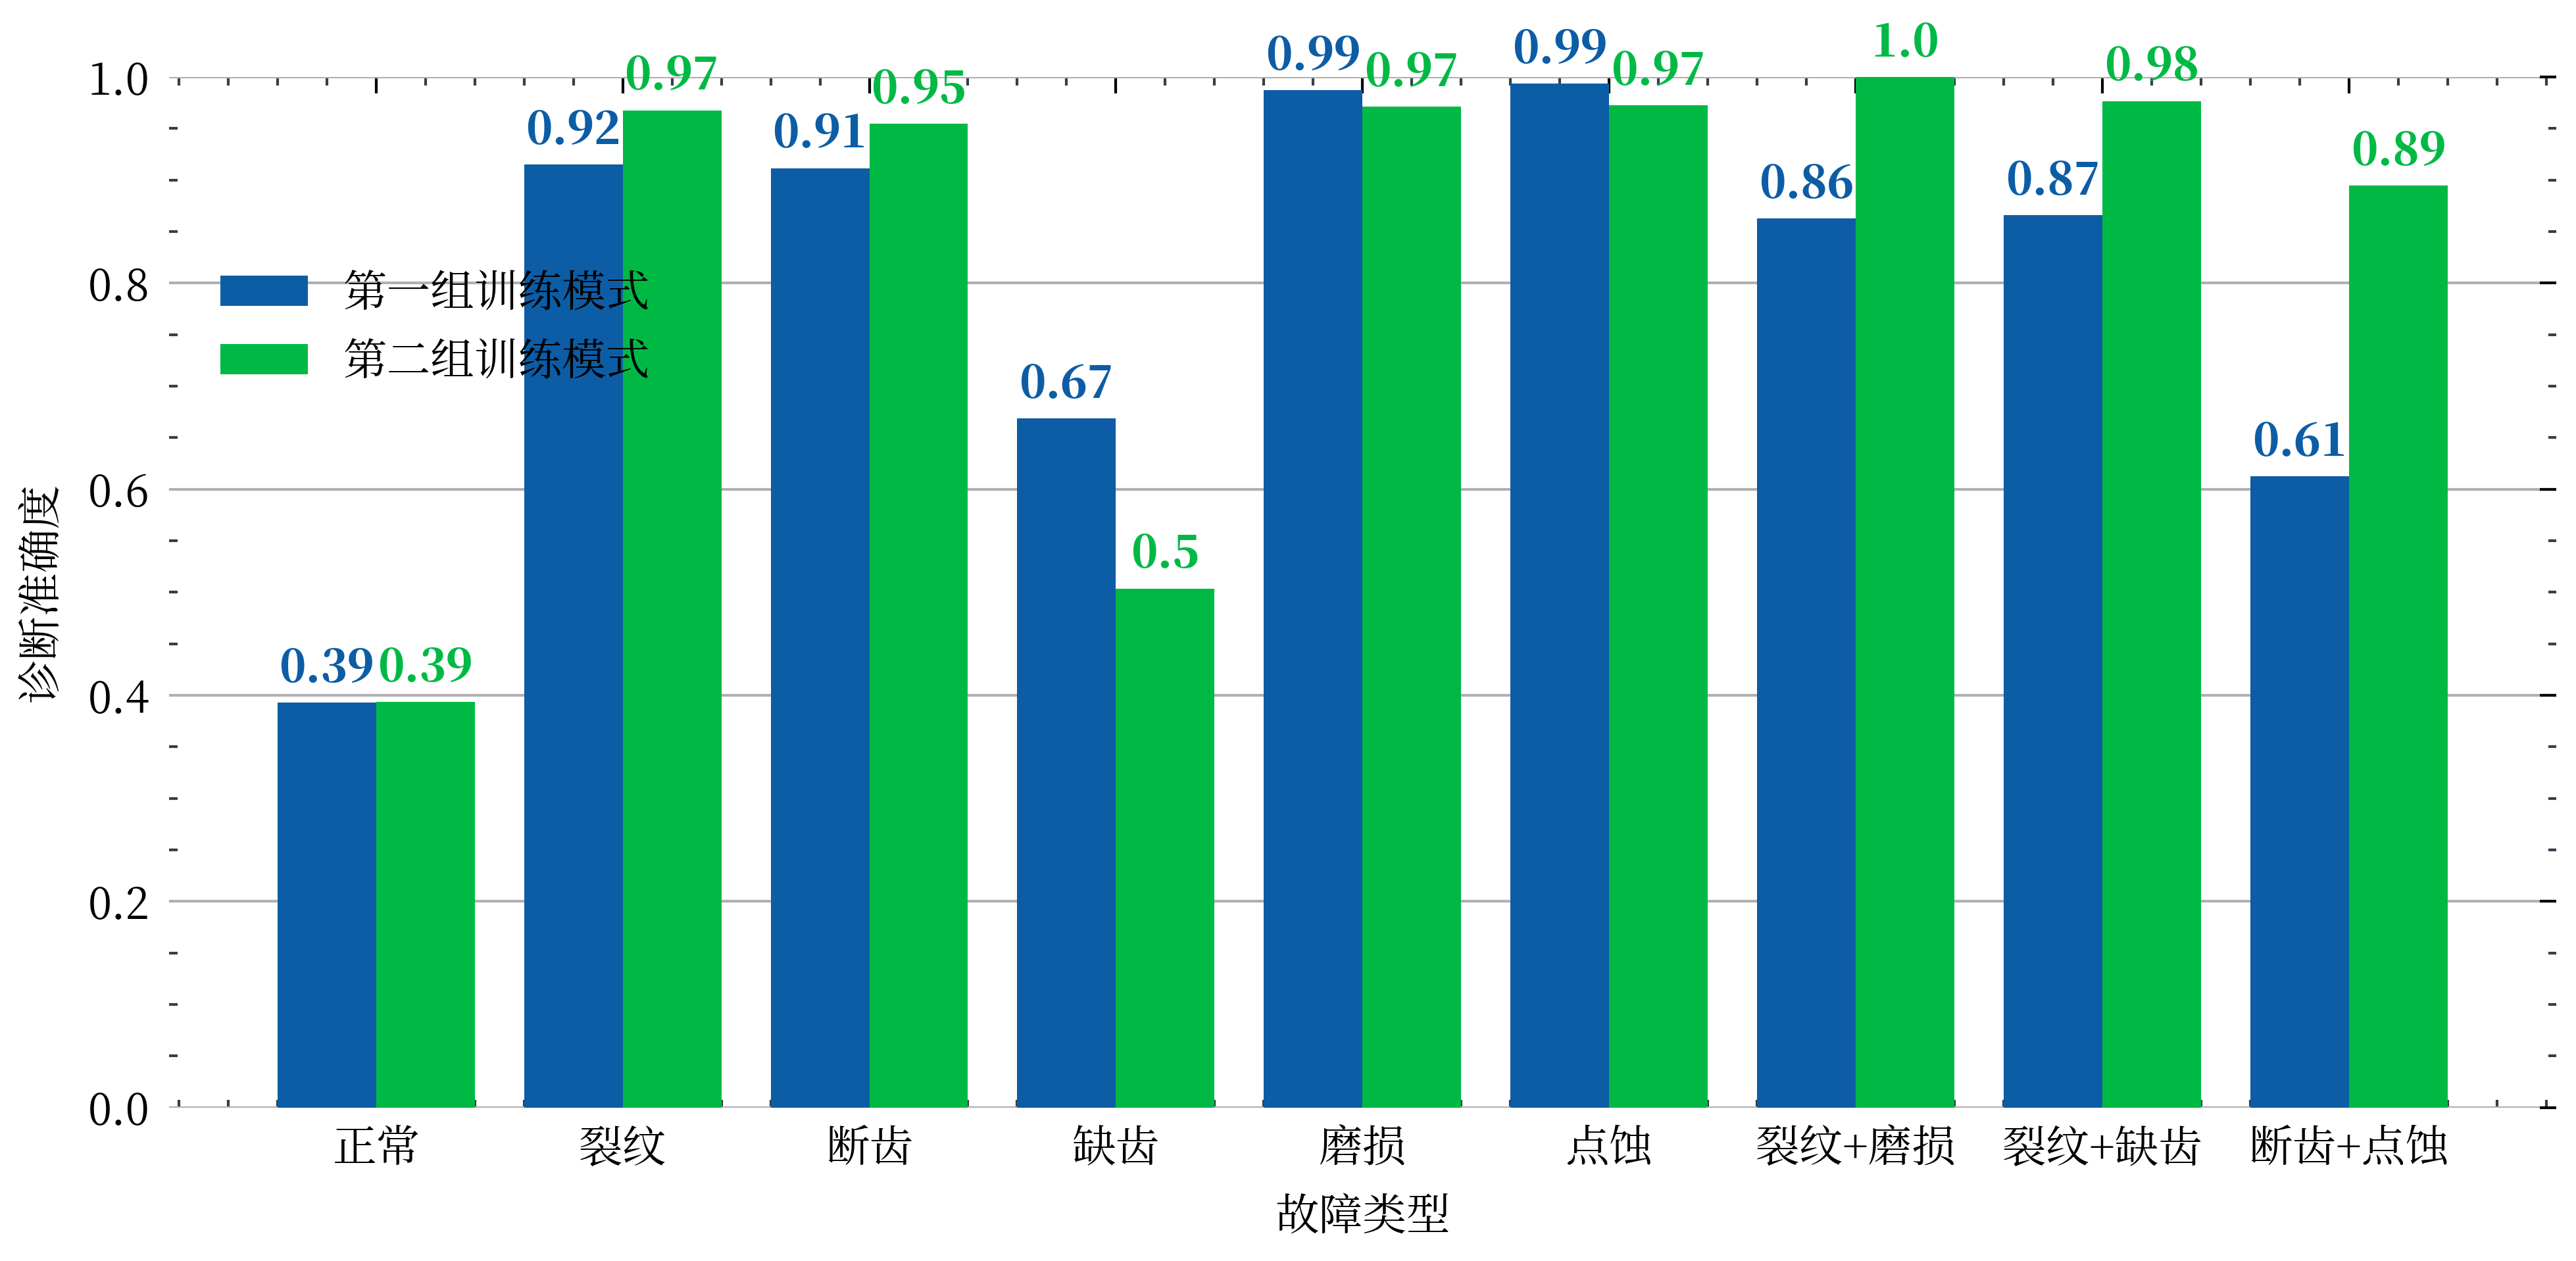

In [167]:
file_path = Path("./result.xlsx")
xl = pd.ExcelFile(file_path)
df1 = xl.parse('train_91')
df2 = xl.parse('trainWithB123')
loc = 120

label = ('正常', '裂纹', '断齿', '缺齿', '磨损', '点蚀', '裂纹+磨损', '裂纹+缺齿', '断齿+点蚀')
group1 = ((df1['B4L09_in_acc0_acc'][loc] + df1['B4L110_in_acc0_acc'][loc] + df1['B4L211_in_acc0_acc'][loc]) / 3,
          (df1['B4L09_in_acc1_acc'][loc] + df1['B4L110_in_acc1_acc'][loc] + df1['B4L211_in_acc1_acc'][loc]) / 3,
          (df1['B4L09_in_acc2_acc'][loc] + df1['B4L110_in_acc2_acc'][loc] + df1['B4L211_in_acc2_acc'][loc]) / 3,
          (df1['B4L09_in_acc3_acc'][loc] + df1['B4L110_in_acc3_acc'][loc] + df1['B4L211_in_acc3_acc'][loc]) / 3,
          (df1['B4L09_in_acc4_acc'][loc] + df1['B4L110_in_acc4_acc'][loc] + df1['B4L211_in_acc4_acc'][loc]) / 3,
          (df1['B4L09_in_acc5_acc'][loc] + df1['B4L110_in_acc5_acc'][loc] + df1['B4L211_in_acc5_acc'][loc]) / 3,
          (df1['B4L09_in_acc6_acc'][loc] + df1['B4L110_in_acc6_acc'][loc] + df1['B4L211_in_acc6_acc'][loc]) / 3,
          (df1['B4L09_in_acc7_acc'][loc] + df1['B4L110_in_acc7_acc'][loc] + df1['B4L211_in_acc7_acc'][loc]) / 3,
          (df1['B4L09_in_acc8_acc'][loc] + df1['B4L110_in_acc8_acc'][loc] + df1['B4L211_in_acc8_acc'][loc]) / 3)
group2 = ((df2['B4L09_in_acc0_acc'][loc] + df2['B4L110_in_acc0_acc'][loc] + df2['B4L211_in_acc0_acc'][loc]) / 3,
          (df2['B4L09_in_acc1_acc'][loc] + df2['B4L110_in_acc1_acc'][loc] + df2['B4L211_in_acc1_acc'][loc]) / 3,
          (df2['B4L09_in_acc2_acc'][loc] + df2['B4L110_in_acc2_acc'][loc] + df2['B4L211_in_acc2_acc'][loc]) / 3,
          (df2['B4L09_in_acc3_acc'][loc] + df2['B4L110_in_acc3_acc'][loc] + df2['B4L211_in_acc3_acc'][loc]) / 3,
          (df2['B4L09_in_acc4_acc'][loc] + df2['B4L110_in_acc4_acc'][loc] + df2['B4L211_in_acc4_acc'][loc]) / 3,
          (df2['B4L09_in_acc5_acc'][loc] + df2['B4L110_in_acc5_acc'][loc] + df2['B4L211_in_acc5_acc'][loc]) / 3,
          (df2['B4L09_in_acc6_acc'][loc] + df2['B4L110_in_acc6_acc'][loc] + df2['B4L211_in_acc6_acc'][loc]) / 3,
          (df2['B4L09_in_acc7_acc'][loc] + df2['B4L110_in_acc7_acc'][loc] + df2['B4L211_in_acc7_acc'][loc]) / 3,
          (df2['B4L09_in_acc8_acc'][loc] + df2['B4L110_in_acc8_acc'][loc] + df2['B4L211_in_acc8_acc'][loc]) / 3)

fig, ax = plt.subplots(1, 1, figsize=(8 / 1.2, 4 / 1.2), dpi=600)
bar_width = 0.4
bars1 = ax.bar(
    x=np.arange(len(label)),
    height=group1,
    width=bar_width
)
bars2 = ax.bar(
    x=np.arange(len(label)) + bar_width,
    height=group2,
    width=bar_width
)
ax.set_xticks(np.arange(len(label)) + 0.5 * bar_width, labels=label)
ax.legend(('第一组训练模式', '第二组训练模式'), loc='upper left', bbox_to_anchor=(0.005, 0.85))

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim(0, 1)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

for bar in bars1:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        round(bar.get_height(), 2),
        horizontalalignment='center',
        color=bars1[0].get_facecolor(),
        weight='bold')
for bar in bars2:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        round(bar.get_height(), 2),
        horizontalalignment='center',
        color=bars2[0].get_facecolor(),
        weight='bold')

ax.set_xlabel('故障类型')
ax.set_ylabel('诊断准确度')
fig.tight_layout()

plt.savefig('figs/detailed_acc_compare.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)


# Fig 4: 各个算法诊断准确度对比

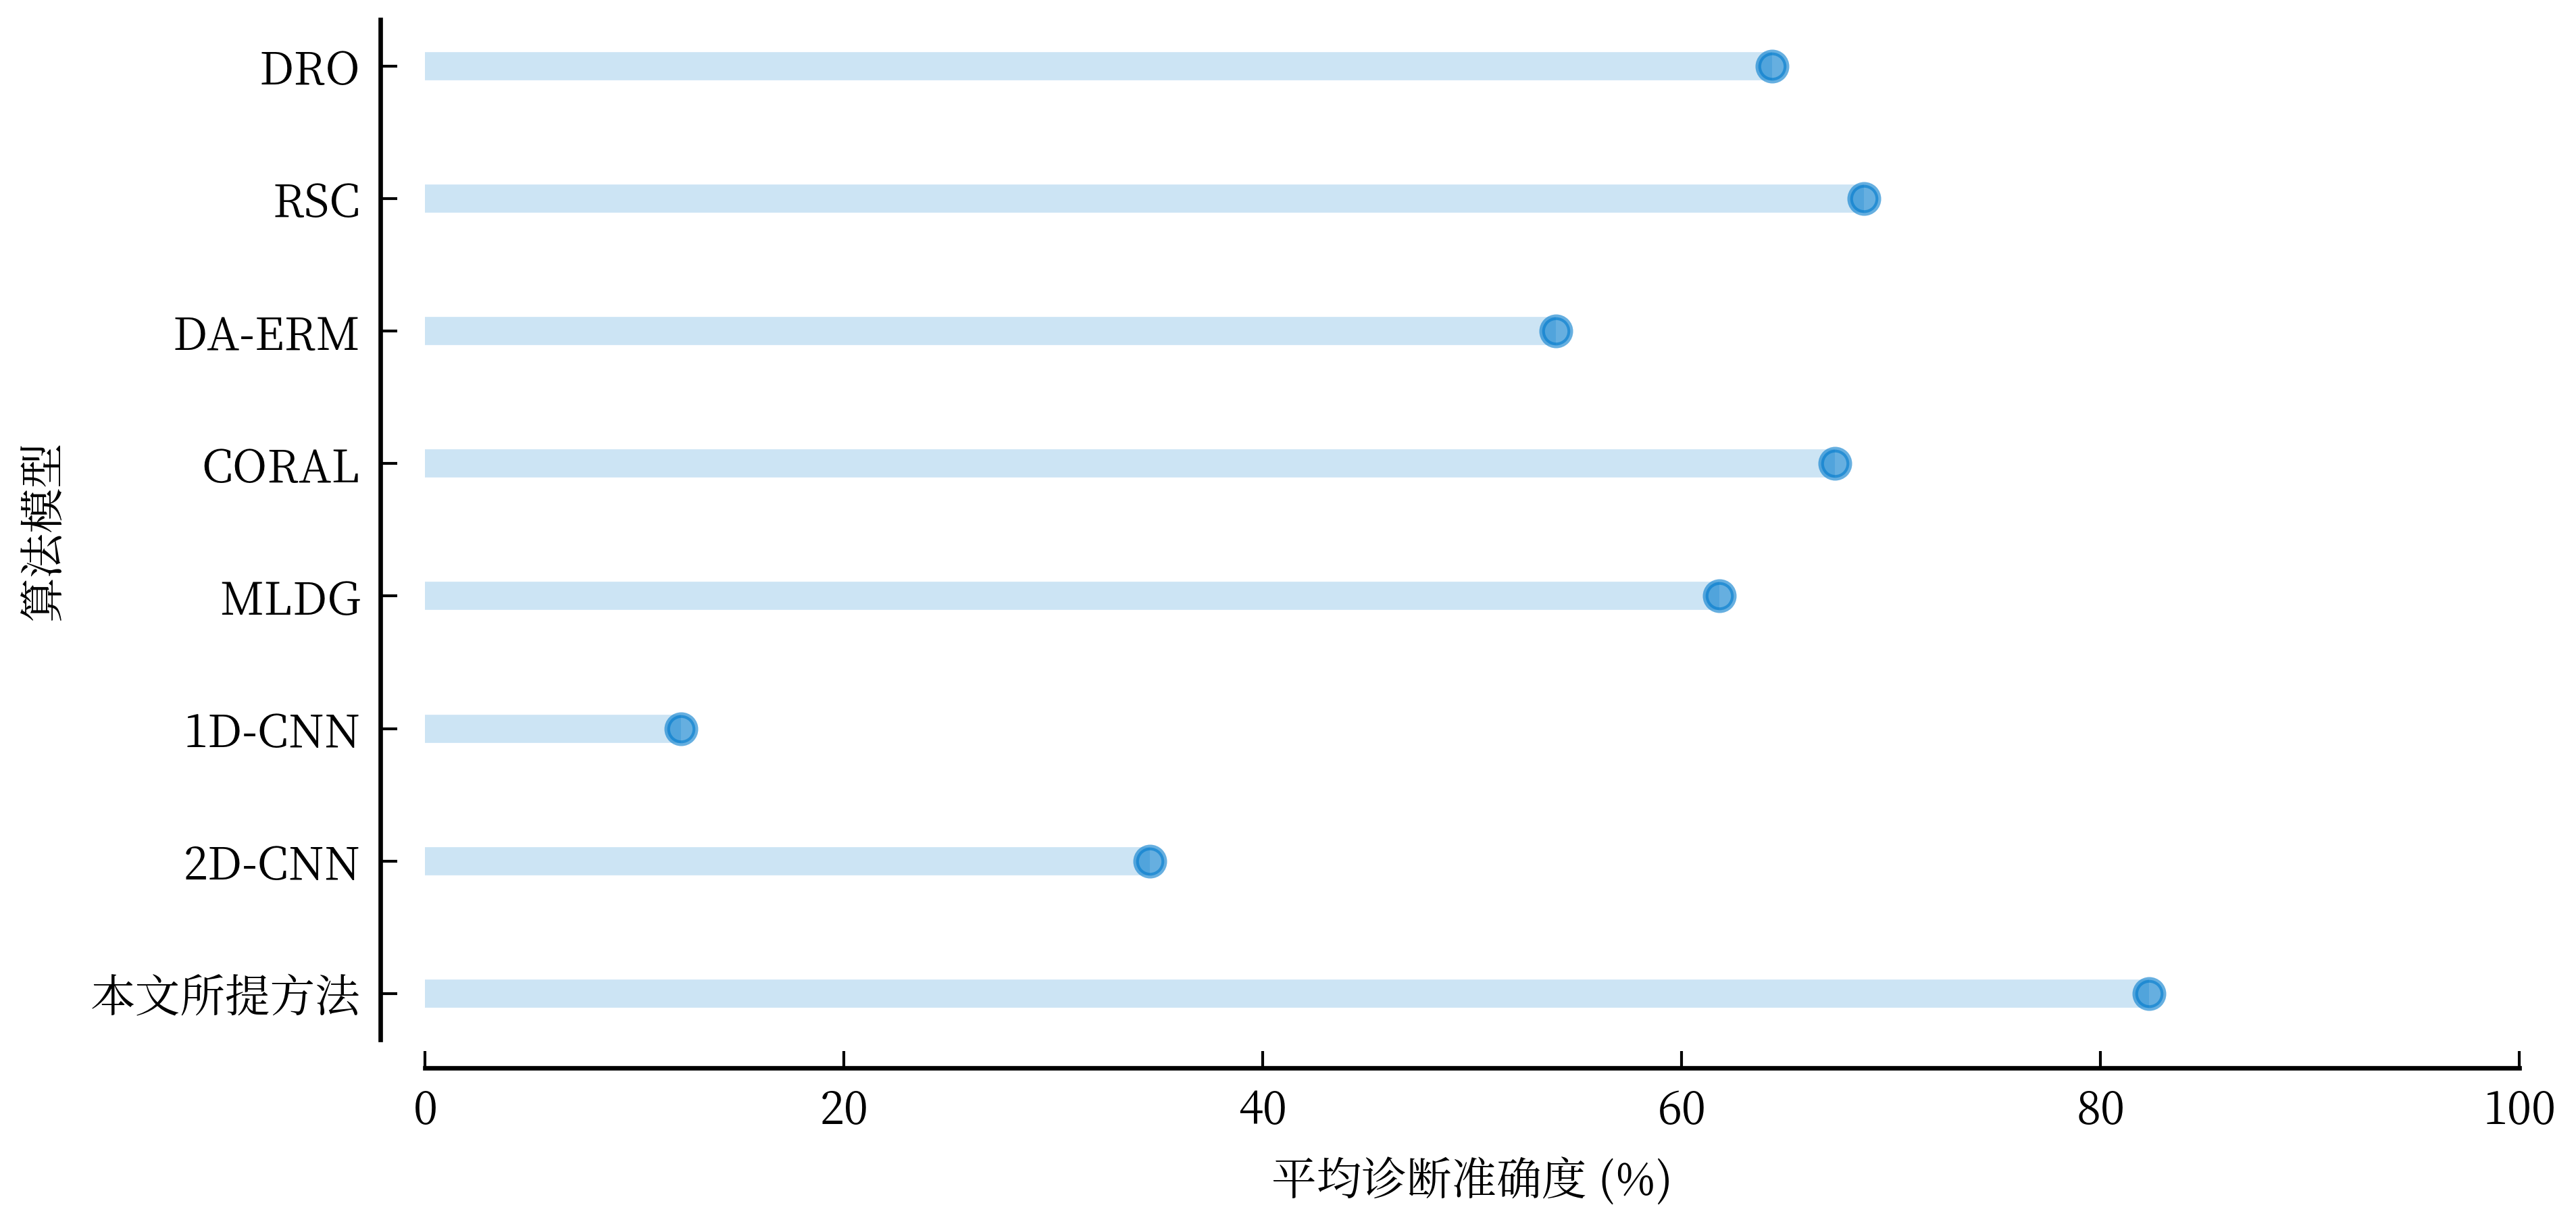

In [203]:
data = [82.3, 34.6, 12.2, 61.8, 67.3, 54.0, 68.7, 64.3]
label = ['本文所提方法', '2D-CNN', '1D-CNN', 'MLDG', 'CORAL', 'DA-ERM', 'RSC', 'DRO']
df = pd.DataFrame(index=label, data=data)

plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333F4B'
plt.rcParams['ytick.color'] = '#333F4B'

my_range = df.index

fig, ax = plt.subplots(1, 1, figsize=(8 / 1.2, 4 / 1.2), dpi=600)
plt.hlines(y=my_range, xmin=0, xmax=df[0], color='#007acc', alpha=0.2, linewidth=5)
plt.plot(df[0], my_range, "o", markersize=5, color='#007acc', alpha=0.6)
ax.set_xlabel('平均诊断准确度 (%)')
ax.set_ylabel('算法模型')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.spines['left'].set_bounds((1, len(my_range)))
ax.set_xlim(0, 100)
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.rcParams['axes.linewidth'] = 0.8
ax.tick_params(bottom=True, top=False, left=True, right=False)
ax.minorticks_off()

plt.savefig('figs/acc_compare.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)


# Fig 5: 参数调优图

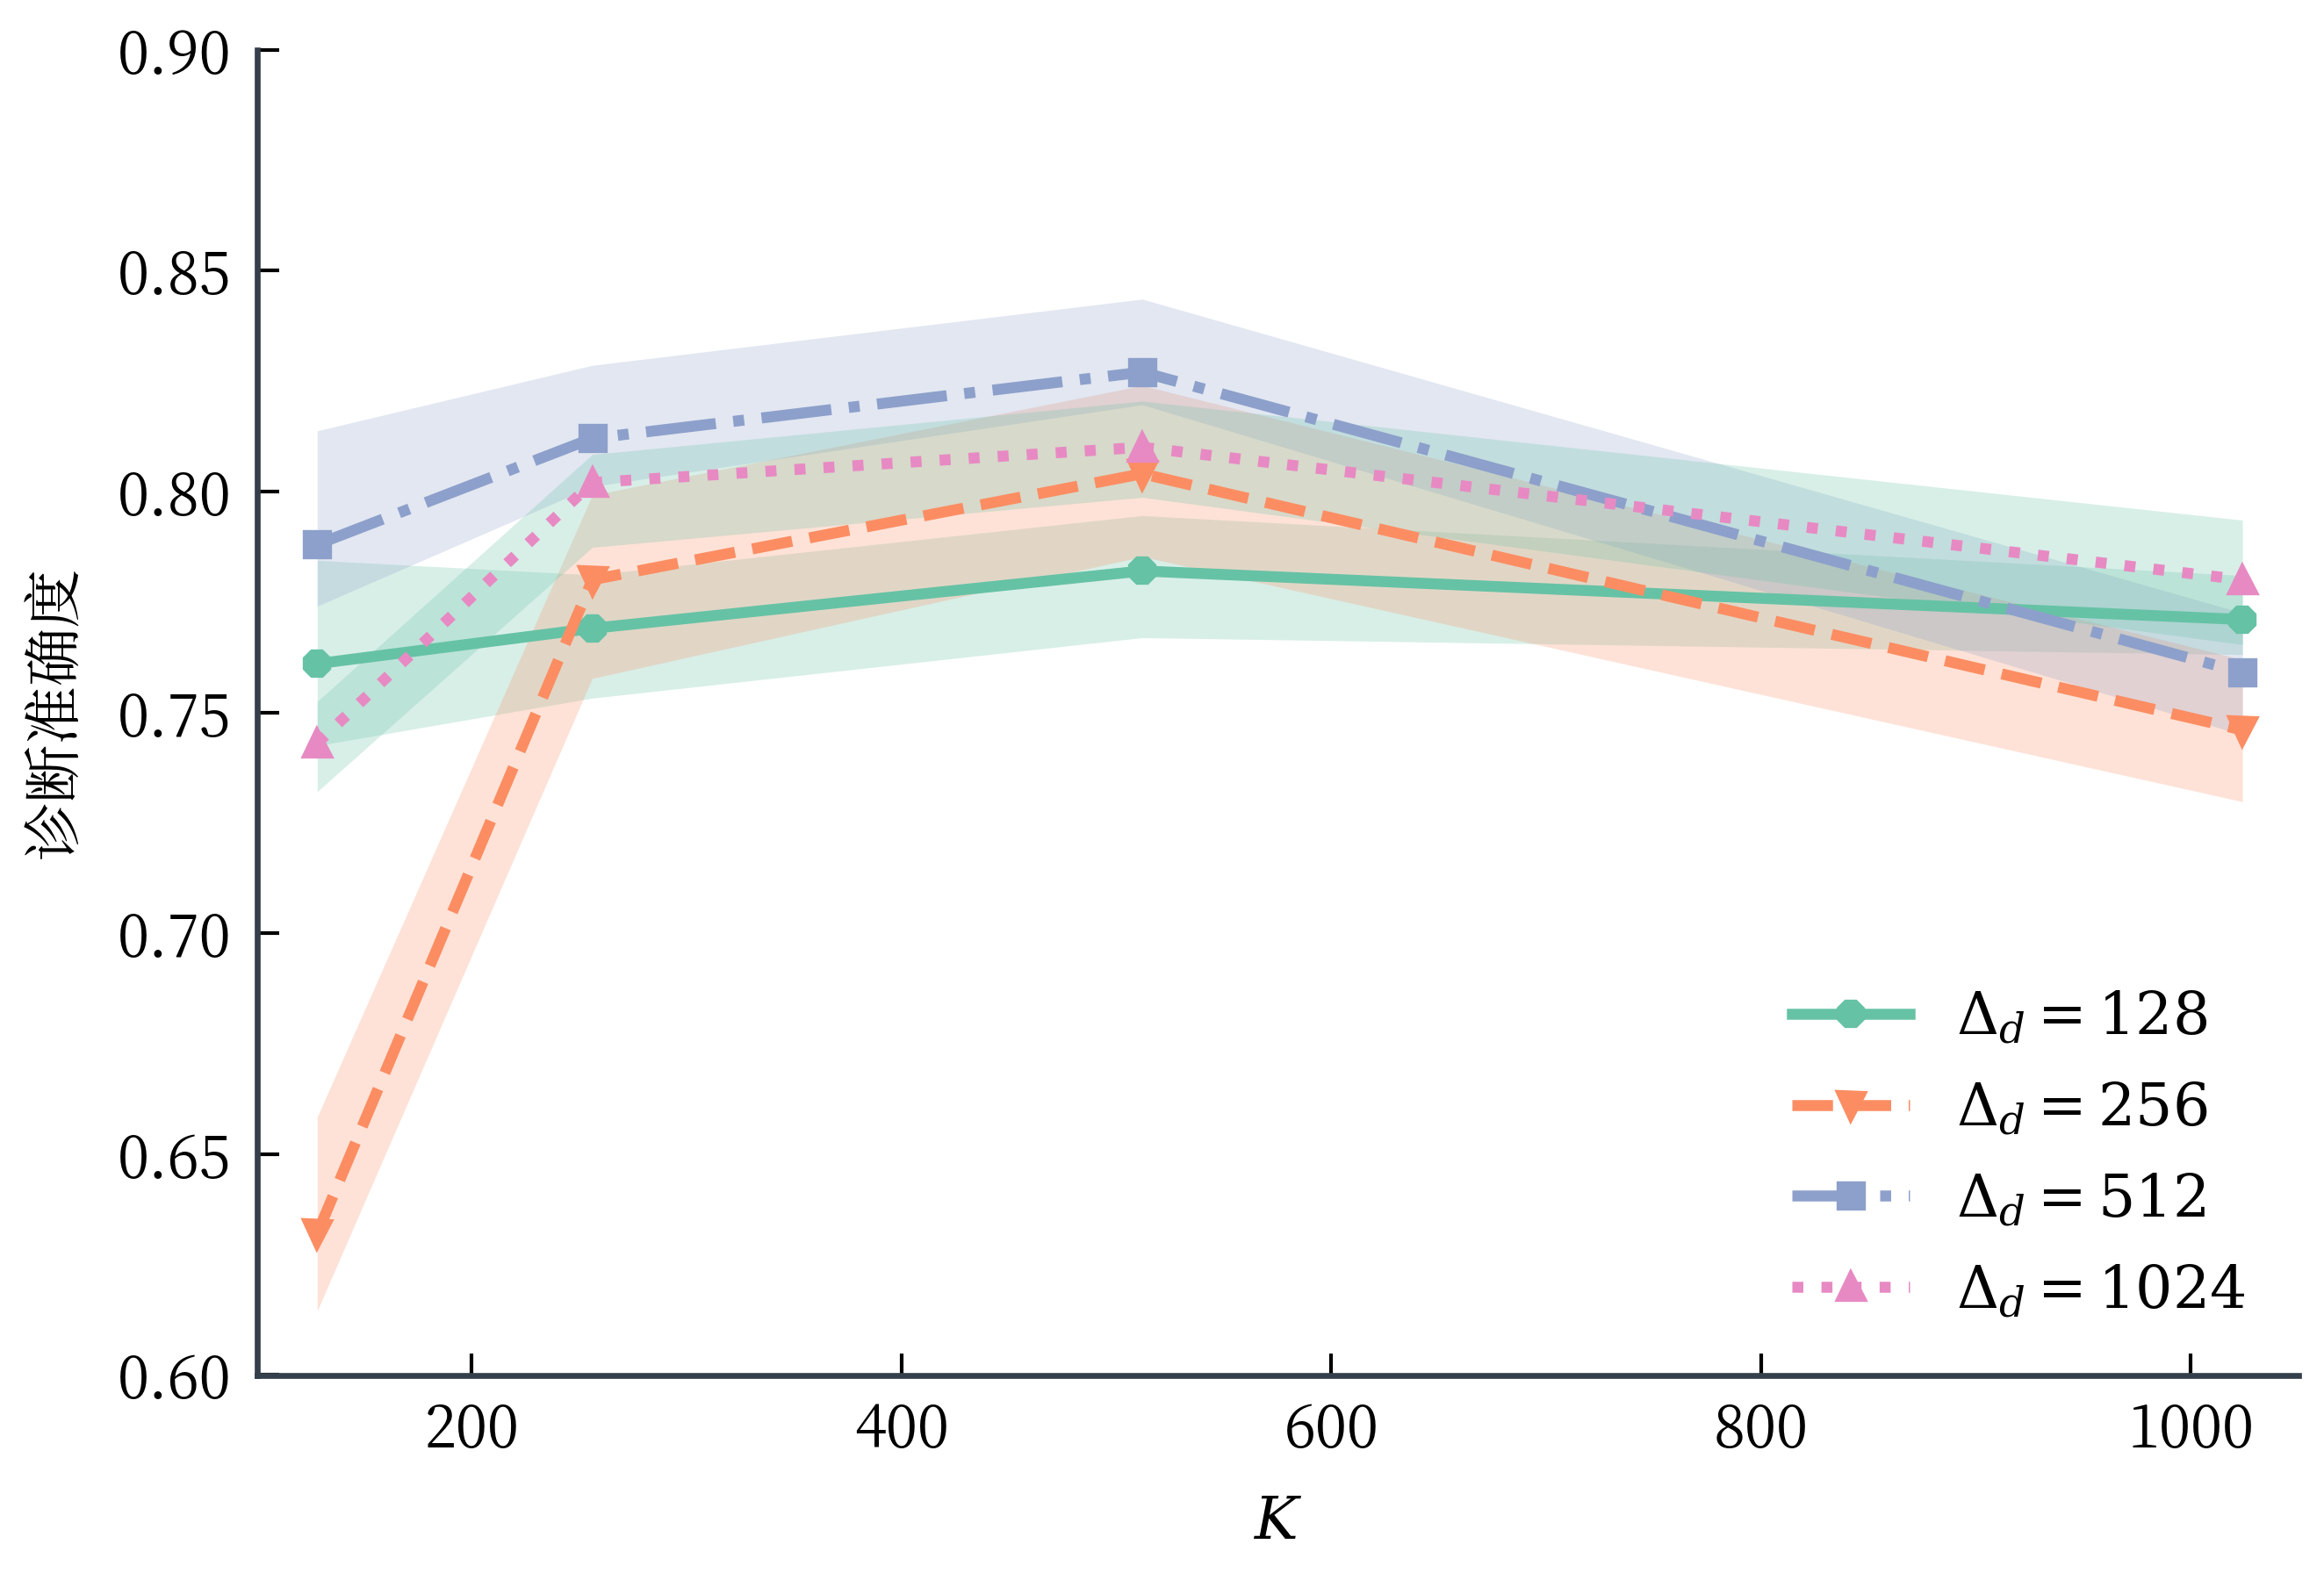

In [293]:
df = pd.DataFrame({'128': [0.761, 0.769, 0.782, 0.771],
                   '256': [0.632, 0.780, 0.804, 0.746],
                   '512': [0.788, 0.812, 0.827, 0.759],
                   '1024': [0.743, 0.802, 0.810, 0.780]},
                  index=['128', '256', '512', '1024'])

x = [128, 256, 512, 1024]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
ax.fill_between(x, df['128'] - np.random.normal(0.015, 0.005, 4), df['128'] + np.random.normal(0.015, 0.005, 4),
                alpha=0.25,
                linewidth=0,
                color=colors[0])
ax.plot(x, df['128'], linestyle='-', marker='8', linewidth=1.5, markersize=3, color=colors[0], label="$\Delta_d=128$")
ax.fill_between(x, df['256'] - np.random.normal(0.015, 0.005, 4), df['256'] + np.random.normal(0.015, 0.005, 4),
                alpha=0.25,
                linewidth=0, color=colors[1])
ax.plot(x, df['256'], linestyle='--', marker='v', linewidth=1.5, markersize=3, color=colors[1], label="$\Delta_d=256$")
ax.fill_between(x, df['512'] - np.random.normal(0.015, 0.005, 4), df['512'] + np.random.normal(0.015, 0.005, 4),
                alpha=0.25,
                linewidth=0, color=colors[2])
ax.plot(x, df['512'], linestyle='-.', marker='s', linewidth=1.5, markersize=3, color=colors[2], label="$\Delta_d=512$")
ax.fill_between(x, df['1024'] - np.random.normal(0.015, 0.005, 4), df['1024'] + np.random.normal(0.015, 0.005, 4),
                alpha=0.25, linewidth=0, color=colors[0])
ax.plot(x, df['1024'], linestyle=':', marker='^', linewidth=1.5, markersize=3, color=colors[3], label="$\Delta_d=1024$")

# change xlim to set_xlim
ax.set_xlim(100, 1050)
ax.set_ylim(0.6, 0.9)

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# 设置x、y轴标签
ax.set_ylabel("诊断准确度")
ax.set_xlabel("$K$")

ax.yaxis.set_minor_locator(MultipleLocator(0.0125))
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.grid(which='minor', c='lightgrey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower right')
ax.tick_params(bottom=True, top=False, left=True, right=False)
ax.minorticks_off()
plt.savefig('figs/tune_1.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)


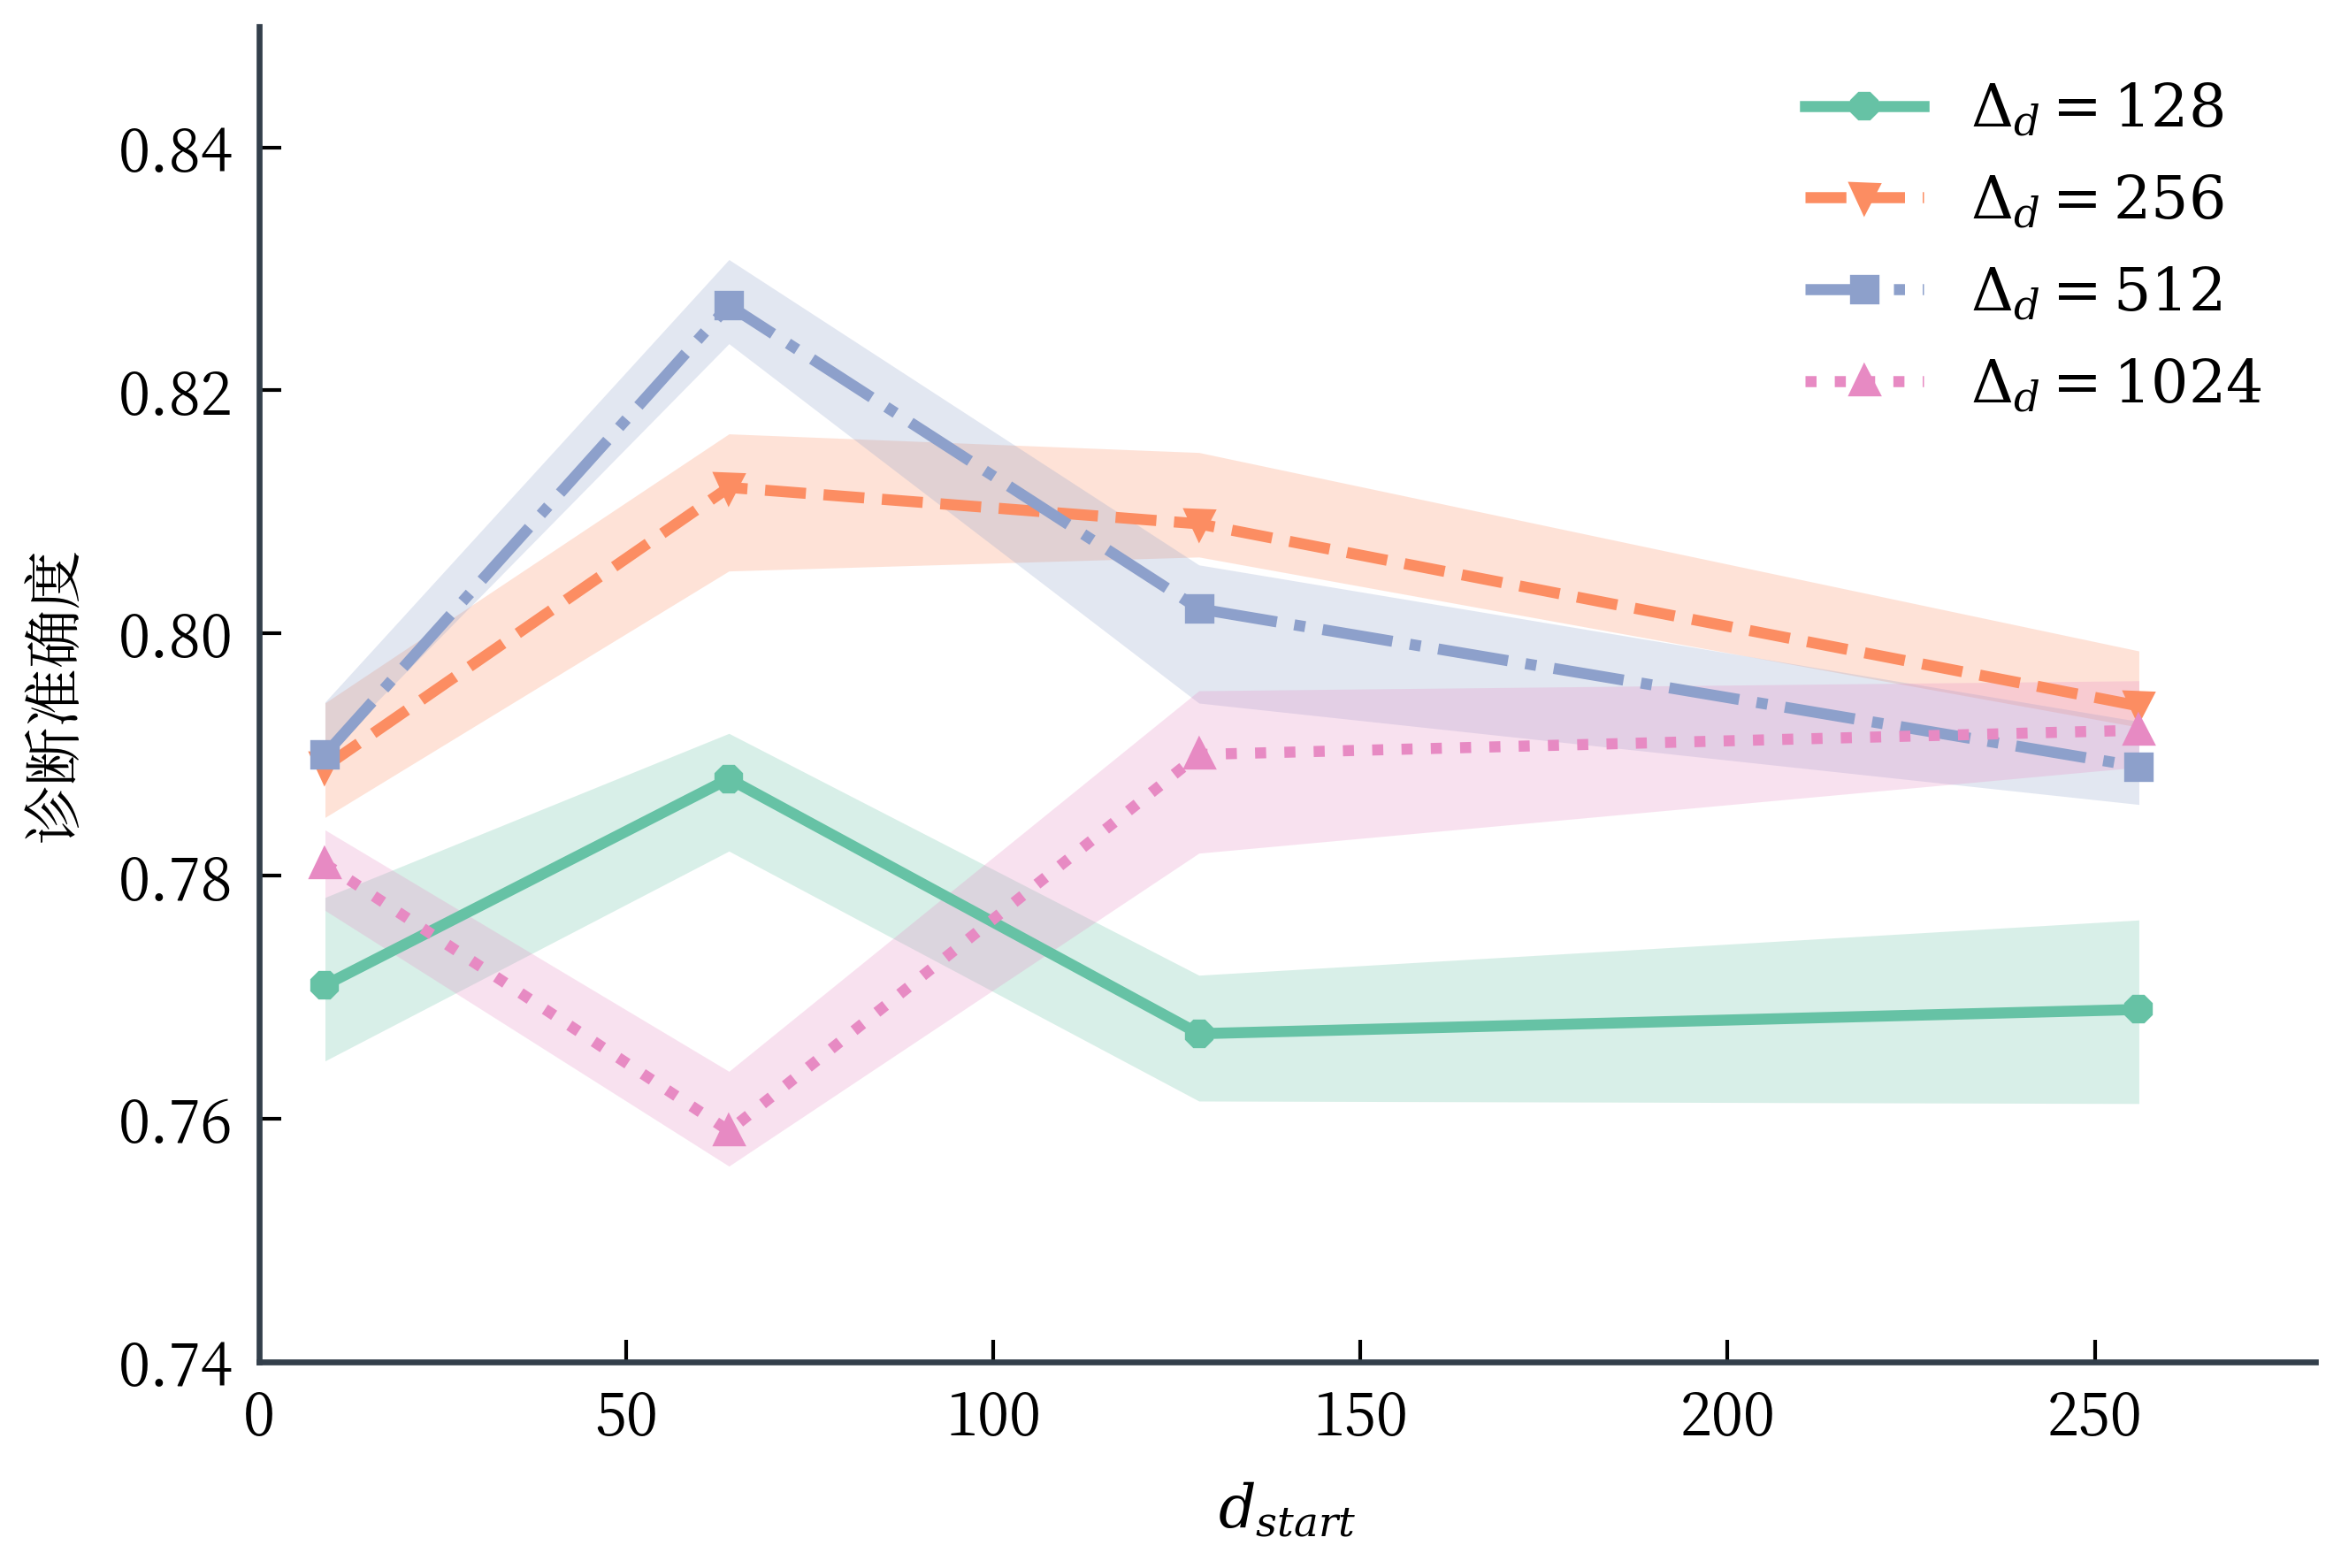

In [331]:
df = pd.DataFrame({'9': [0.771, 0.789, 0.790, 0.781],
                   '64': [0.788, 0.812, 0.827, 0.759],
                   '128': [0.767, 0.809, 0.802, 0.790],
                   '256': [0.769, 0.794, 0.789, 0.792]},
                  index=['128', '256', '512', '1024'])

x = [9, 64, 128, 256]

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
ax.fill_between(x, df.loc['128'] - np.random.normal(0.005, 0.002, 4), df.loc['128'] + np.random.normal(0.005, 0.002, 4),
                alpha=0.25,
                linewidth=0,
                color=colors[0])
ax.plot(x, df.loc['128'], linestyle='-', marker='8', linewidth=1.5, markersize=3, color=colors[0],
        label="$\Delta_d=128$")
ax.fill_between(x, df.loc['256'] - np.random.normal(0.005, 0.002, 4), df.loc['256'] + np.random.normal(0.005, 0.002, 4),
                alpha=0.25,
                linewidth=0, color=colors[1])
ax.plot(x, df.loc['256'], linestyle='--', marker='v', linewidth=1.5, markersize=3, color=colors[1],
        label="$\Delta_d=256$")
ax.fill_between(x, df.loc['512'] - np.random.normal(0.005, 0.002, 4), df.loc['512'] + np.random.normal(0.005, 0.002, 4),
                alpha=0.25,
                linewidth=0, color=colors[2])
ax.plot(x, df.loc['512'], linestyle='-.', marker='s', linewidth=1.5, markersize=3, color=colors[2],
        label="$\Delta_d=512$")
ax.fill_between(x, df.loc['1024'] - np.random.normal(0.005, 0.002, 4),
                df.loc['1024'] + np.random.normal(0.005, 0.002, 4),
                alpha=0.25, linewidth=0, color=colors[3])
ax.plot(x, df.loc['1024'], linestyle=':', marker='^', linewidth=1.5, markersize=3, color=colors[3],
        label="$\Delta_d=1024$")

# change xlim to set_xlim
ax.set_xlim(0, 280)
ax.set_ylim(0.74, 0.85)

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# 设置x、y轴标签
ax.set_ylabel("诊断准确度")
ax.set_xlabel("$d_{start}$")

ax.yaxis.set_minor_locator(MultipleLocator(0.0125))
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.grid(which='minor', c='lightgrey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='upper right')
ax.tick_params(bottom=True, top=False, left=True, right=False)
ax.minorticks_off()
plt.savefig('figs/tune_2.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)


# Fig 6: PCA plot

In [8]:
from pathlib import Path
from domainbed.scripts.preprocess import PCA
from domainbed.scripts.clustering import Faiss_Clustering
from domainbed.scripts.helpers import get_cluster_labels, get_images_list
import numpy as np
import torch

feature_path = Path("D:\\shareFiles\\features.txt")
label_path = Path("D:\\shareFiles\\labels.txt")

features = np.loadtxt(feature_path)
labels = np.loadtxt(label_path)

# PCA process
num_clusters = 512
train_features_pca = features
pca = PCA(512)
exp_var = pca.fit(features, 8)  # offset = 8 (PCAd的起始点)
train_features2 = pca.apply(
    torch.from_numpy(train_features_pca)).detach().numpy()  # train_features2 = {ndarray: (N, 512)}
row_sums = np.linalg.norm(train_features2, axis=1)
train_features2 = train_features2 / row_sums[:, np.newaxis]

train_features2

array([[-0.0697256 , -0.04265735, -0.05119032, ...,  0.06580888,
        -0.02159526,  0.05954346],
       [-0.06861368, -0.05094273, -0.05863966, ...,  0.06179155,
        -0.01994299,  0.05329782],
       [-0.07134464, -0.05721619, -0.06108938, ...,  0.05772796,
        -0.02085369,  0.06120929],
       ...,
       [-0.06131377, -0.06638518, -0.06305614, ...,  0.05965246,
        -0.00837084,  0.06512522],
       [-0.06585395, -0.05569103, -0.0611087 , ...,  0.06816274,
        -0.01070264,  0.0590669 ],
       [-0.06018103, -0.05336683, -0.07189545, ...,  0.06561161,
        -0.01880809,  0.05176049]])

In [9]:
clustering = Faiss_Clustering(train_features2.copy(order="C"), num_clusters)
clustering.fit()
cluster_labels_train = get_cluster_labels(clustering, train_features2)  # cluster_labels_train = {list: N}
images_lists = get_images_list(num_clusters, len(features),
                               cluster_labels_train)  # image_lists = {list: num_clusters}

TypeError: Wrong number or type of arguments for overloaded function 'Clustering_train'.
  Possible C/C++ prototypes are:
    faiss::Clustering::train(faiss::Clustering::idx_t,float const *,faiss::Index &,float const *)
    faiss::Clustering::train(faiss::Clustering::idx_t,float const *,faiss::Index &)
